# Comparison of anomalies for different approaches:
1) Abnormal time in area.
2) Differences in 2D trajectories (latitude and longitude).
3) Differences in 3D trajectories (latitude, longitude and altitude).
4) Differences in groundspeed and vertical rate.
5) Differences in 3D trajectories including groundspeed and vertical rate.
6) Differences in Specific Total Energy (STE) 
7) Differences in Potential Flight Path Angle (PFPA).

In [31]:
# Import required libraries
import os
from traffic.core import Traffic, Flight
from traffic.data import airports
from traffic.data import opensky, eurofirs
from cartes.crs import EPSG_2180
import matplotlib.pyplot as plt
from pyproj import Transformer
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from matplotlib.dates import DateFormatter
import time
import plotly.express as px
import re
from bs4 import BeautifulSoup
import plotly.graph_objects as go
import seaborn as sns
import pandas as pd
from sklearn.metrics import silhouette_score
import ruptures as rpt
import matplotlib.gridspec as gridspec
import hdbscan
from anomatools.models import kNNO
from tqdm import tqdm
from dtaidistance import dtw_ndim
from sklearn.neighbors import NearestNeighbors
import calendar

## Abnormal time in area flights

In [3]:
abnormal_time_in_area_traffic = Traffic.from_file("abnormal_time_in_area_traffic.parquet")
abnormal_time_in_area_traffic

icao24 callsign  count
0  461e1f  FIN1143   3623
1  489328   LOT3VT   3490
2  48932b   LOT3VT   3371
3  48ada5   LOT3VM   3143
4  8964d3  FDB1829   3034
5  48ad80   LOT48F   3032
6  48af03   LOT48F   2960
7  48ada6   LOT3VM   2705
8  461e1a  FIN1143   2569
9  4601f9   FIN8AL   2508

In [4]:
print(f"Number of flights: {len(abnormal_time_in_area_traffic)}")

Number of flights: 68


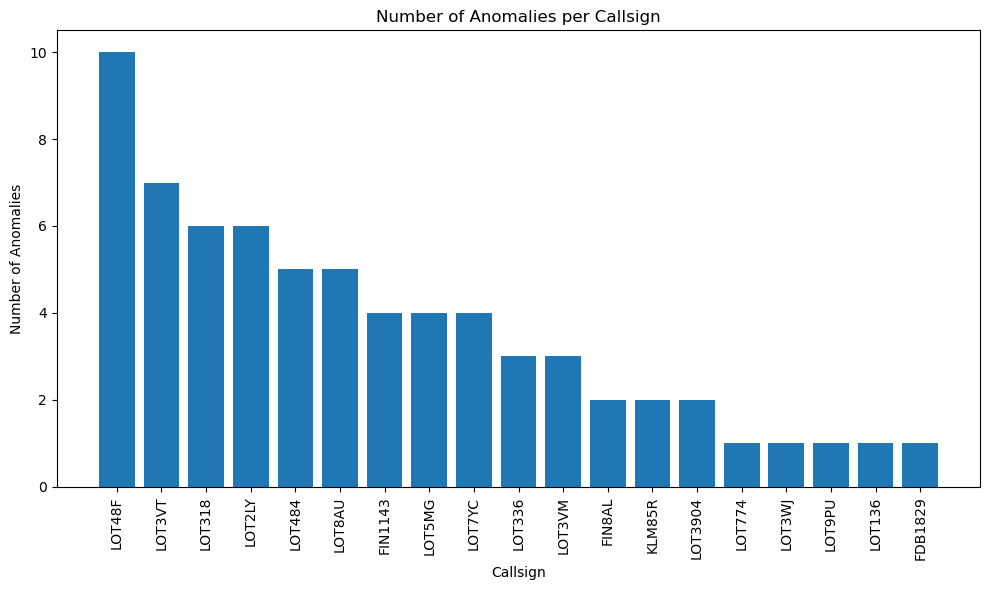

In [8]:
abnormal_time_anomalies_per_callsign = {}

for flight in abnormal_time_in_area_traffic:
    callsign = flight.callsign
    if callsign not in abnormal_time_anomalies_per_callsign:
        abnormal_time_anomalies_per_callsign[callsign] = 0
    abnormal_time_anomalies_per_callsign[callsign] += 1

sorted_anomalies = dict(sorted(abnormal_time_anomalies_per_callsign.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.bar(sorted_anomalies.keys(), sorted_anomalies.values())
plt.xlabel('Callsign')
plt.ylabel('Number of Anomalies')
plt.title('Number of Anomalies per Callsign')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

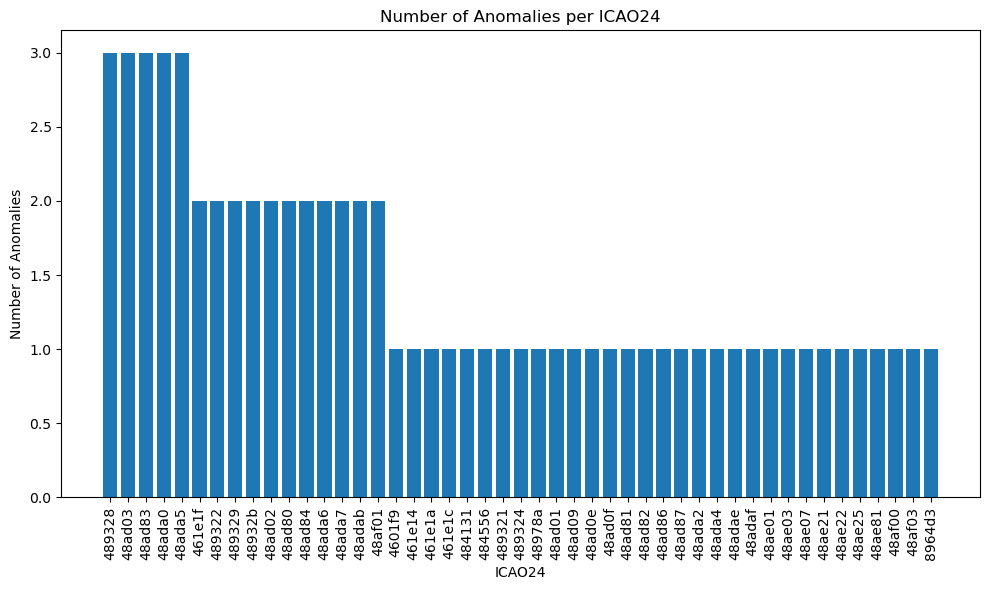

In [9]:
abnormal_time_anomalies_per_icao24 = {}
for flight in abnormal_time_in_area_traffic:
    icao24 = flight.icao24
    if icao24 not in abnormal_time_anomalies_per_icao24:
        abnormal_time_anomalies_per_icao24[icao24] = 0
    abnormal_time_anomalies_per_icao24[icao24] += 1
    
sorted_anomalies_icao24 = dict(sorted(abnormal_time_anomalies_per_icao24.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(10, 6))
plt.bar(sorted_anomalies_icao24.keys(), sorted_anomalies_icao24.values())
plt.xlabel('ICAO24')
plt.ylabel('Number of Anomalies')
plt.title('Number of Anomalies per ICAO24')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

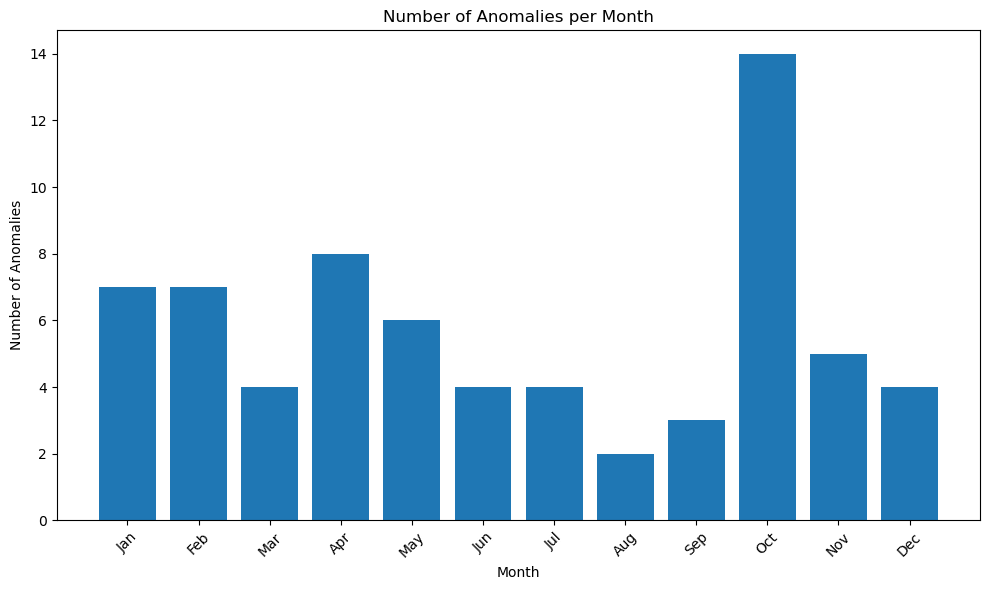

In [13]:
import calendar

abnormal_time_anomalies_per_month = {}
for flight in abnormal_time_in_area_traffic:
    month = flight.start.month
    if month not in abnormal_time_anomalies_per_month:
        abnormal_time_anomalies_per_month[month] = 0
    abnormal_time_anomalies_per_month[month] += 1
    
sorted_anomalies_month = dict(sorted(abnormal_time_anomalies_per_month.items()))

month_names = [calendar.month_abbr[m] for m in sorted_anomalies_month.keys()]

plt.figure(figsize=(10, 6))
plt.bar(month_names, sorted_anomalies_month.values())
plt.xlabel('Month')
plt.ylabel('Number of Anomalies')
plt.title('Number of Anomalies per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


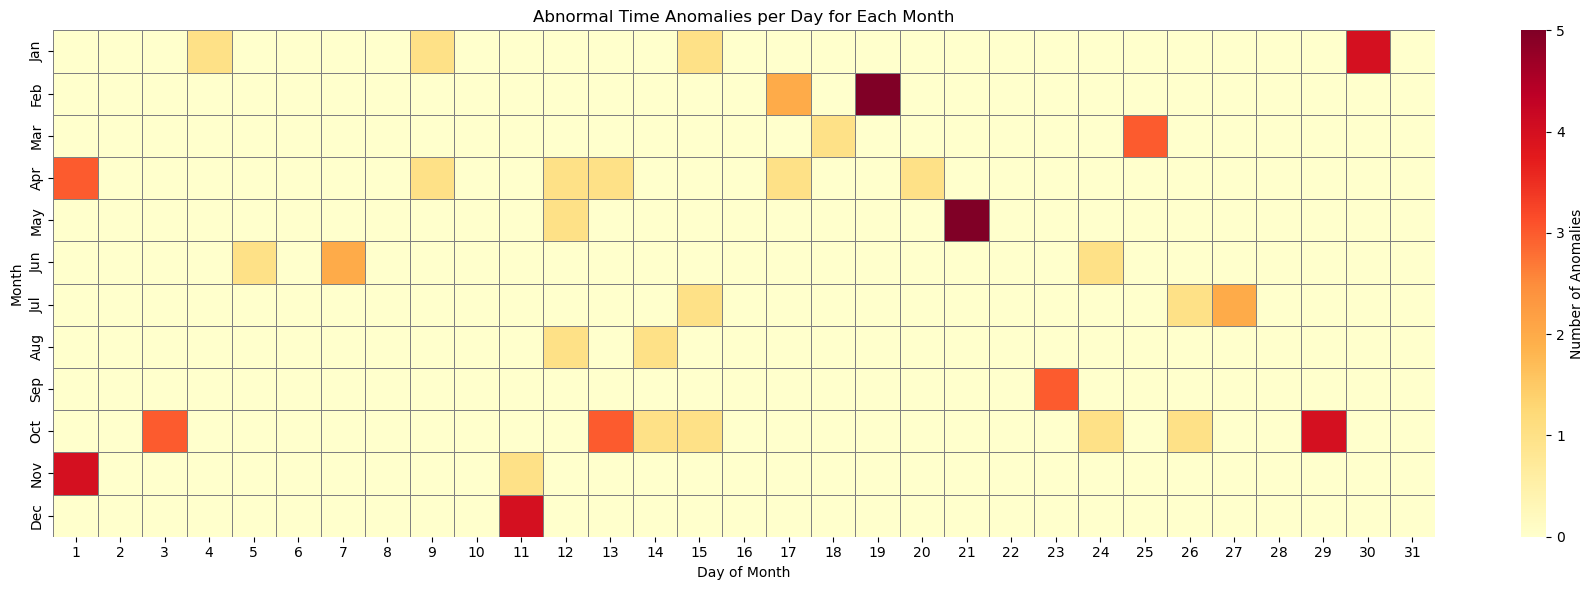

In [14]:
import calendar

# Create a dictionary to hold counts per (month, day)
anomalies_per_month_day = {}

for flight in abnormal_time_in_area_traffic:
    month = flight.start.month
    day = flight.start.day
    key = (month, day)
    if key not in anomalies_per_month_day:
        anomalies_per_month_day[key] = 0
    anomalies_per_month_day[key] += 1

# Create a DataFrame for easier plotting
max_days = 31
months = range(1, 13)
days = range(1, max_days + 1)
data = np.zeros((12, max_days), dtype=int)

for (month, day), count in anomalies_per_month_day.items():
    data[month - 1, day - 1] = count

df_grid = pd.DataFrame(data, index=[calendar.month_abbr[m] for m in months], columns=range(1, max_days + 1))

plt.figure(figsize=(18, 6))
sns.heatmap(df_grid, cmap="YlOrRd", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Number of Anomalies'})
plt.xlabel('Day of Month')
plt.ylabel('Month')
plt.title('Abnormal Time Anomalies per Day for Each Month')
plt.tight_layout()
plt.show()

## Abnormal 2D trajectories flights

In [87]:
def load_dtw_flights_from_folder(folder_name):
    flights = []
    for filename in os.listdir(folder_name):
        if filename.endswith(".parquet"):
            filepath = os.path.join(folder_name, filename)
            traffic = Traffic.from_file(filepath)
            for flight in traffic:
                flights.append(flight)
    return Traffic.from_flights(flights)

In [88]:
dtw_2d_folder = "dtw_2d"
dtw_2d_traffic = load_dtw_flights_from_folder(dtw_2d_folder)

In [18]:
dtw_2d_traffic

icao24 callsign  count
0  489324   LOT3VT   6903
1  48ae01   LOT2LY   6644
2  489329   LOT3VT   4987
3  8964d3  FDB1829   4152
4  461e1f  FIN1143   3623
5  489328   LOT3VT   3490
6  48ad81   LOT774   3481
7  489329  LOT3904   3387
8  48932b   LOT3VT   3371
9  48adab   LOT136   3363

In [18]:
print(f"Number of flights: {len(dtw_2d_flights)}")

Number of flights: 265


In [ ]:
def plot_anomalies_per_callsign(traffic, title_suffix=""):
    anomalies_per_callsign = {}
    for flight in traffic:
        callsign = flight.callsign
        if callsign not in anomalies_per_callsign:
            anomalies_per_callsign[callsign] = 0
        anomalies_per_callsign[callsign] += 1
    sorted_anomalies = dict(sorted(anomalies_per_callsign.items(), key=lambda item: item[1], reverse=True))
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_anomalies.keys(), sorted_anomalies.values())
    plt.xlabel('Callsign')
    plt.ylabel('Number of Anomalies')
    plt.title(f'Number of Anomalies per Callsign{title_suffix}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

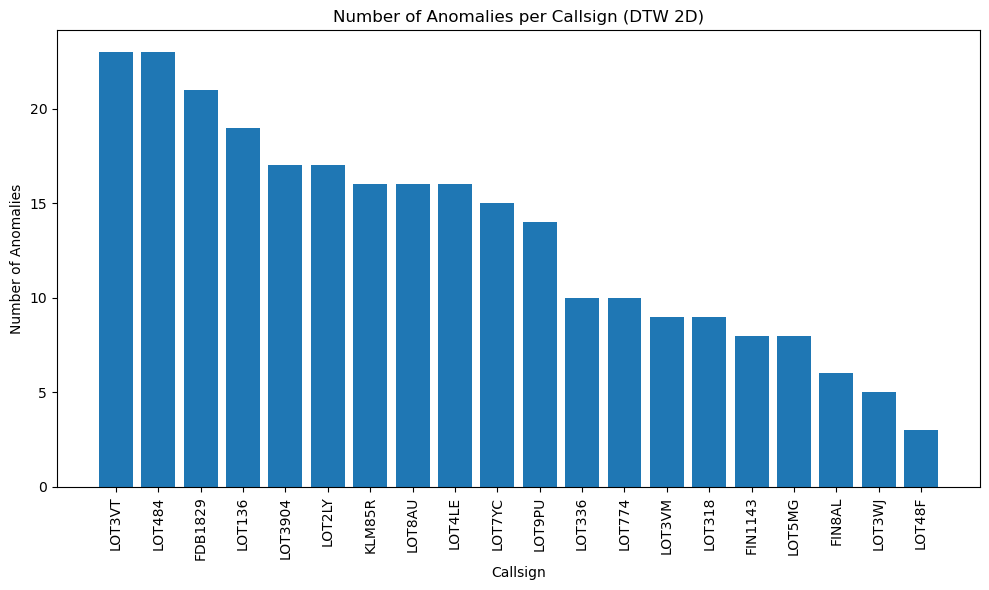

In [41]:
plot_anomalies_per_callsign(dtw_2d_traffic, " (DTW 2D)")

In [43]:
def plot_anomalies_per_icao24(traffic, title_suffix=""):
    anomalies_per_icao24 = {}
    for flight in traffic:
        icao24 = flight.icao24
        if icao24 not in anomalies_per_icao24:
            anomalies_per_icao24[icao24] = 0
        anomalies_per_icao24[icao24] += 1
    sorted_anomalies_icao24 = dict(sorted(anomalies_per_icao24.items(), key=lambda item: item[1], reverse=True))
    plt.figure(figsize=(20, 6))
    plt.bar(sorted_anomalies_icao24.keys(), sorted_anomalies_icao24.values())
    plt.xlabel('ICAO24')
    plt.ylabel('Number of Anomalies')
    plt.title(f'Number of Anomalies per ICAO24{title_suffix}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

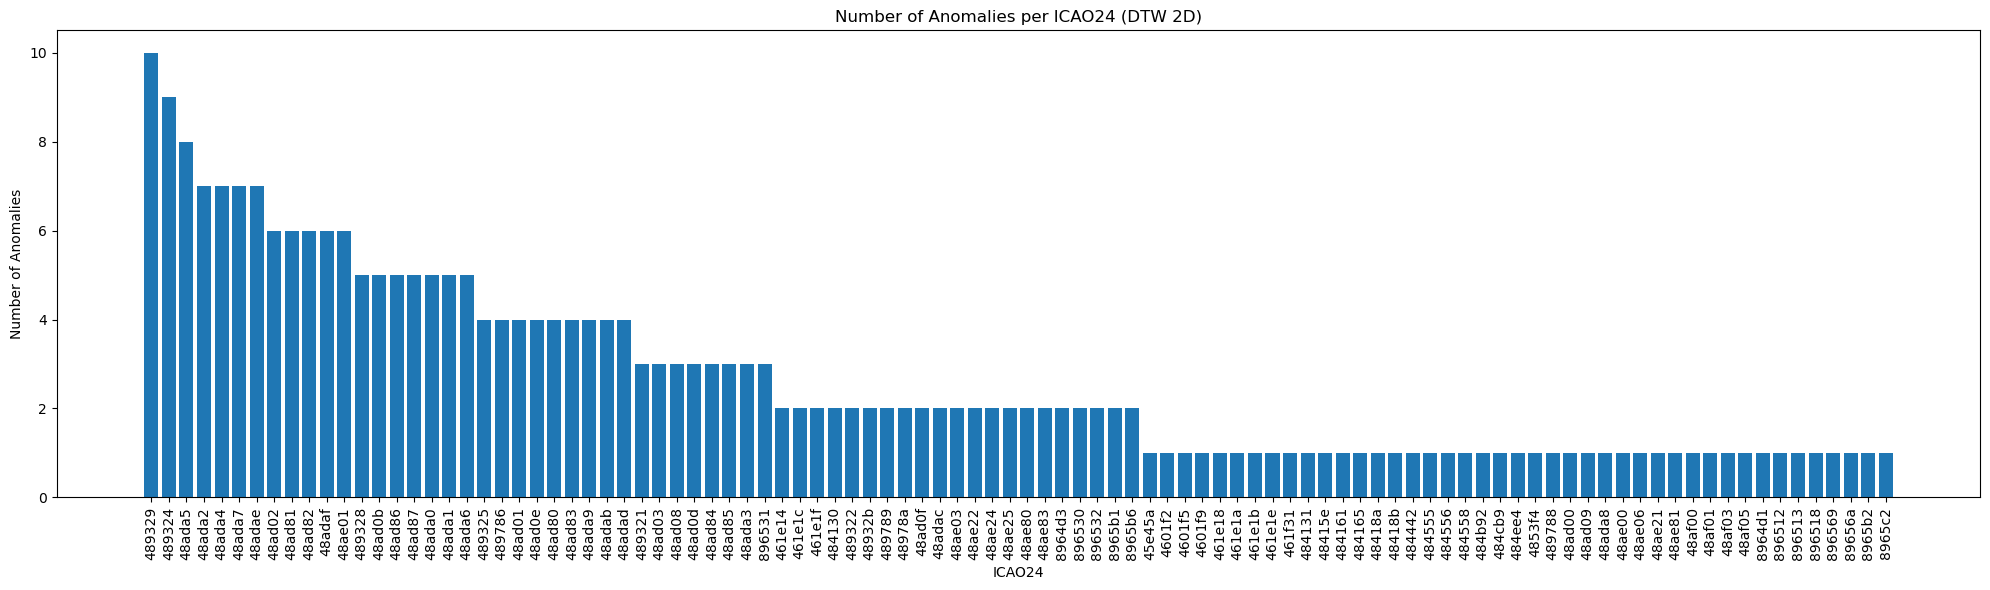

In [44]:
plot_anomalies_per_icao24(dtw_2d_traffic, " (DTW 2D)")

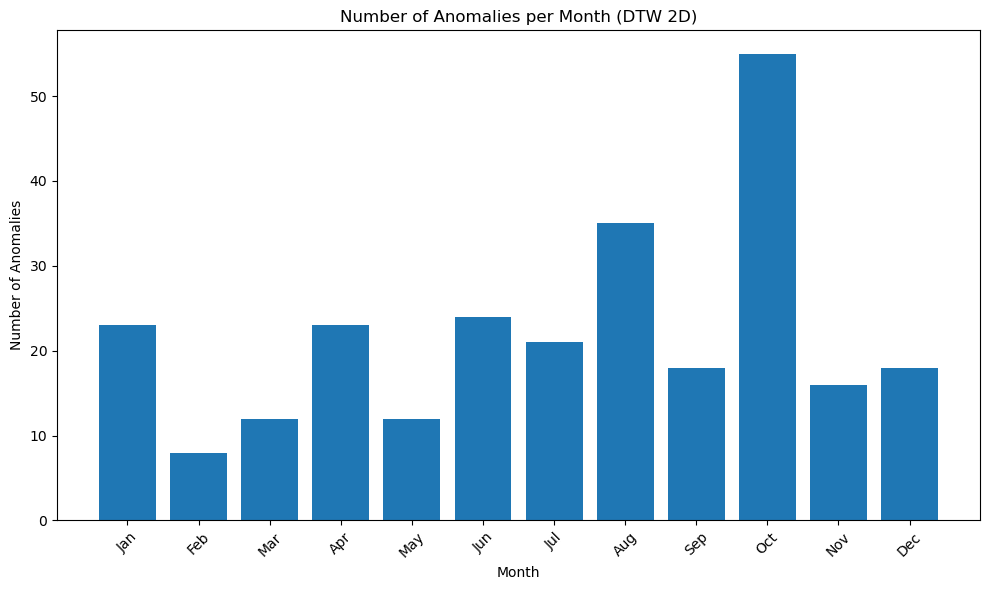

In [46]:
def plot_anomalies_per_month(traffic, title_suffix=""):
    dtw_2d_anomalies_per_month = {}
    for flight in traffic:
        month = flight.start.month
        if month not in dtw_2d_anomalies_per_month:
            dtw_2d_anomalies_per_month[month] = 0
        dtw_2d_anomalies_per_month[month] += 1

    sorted_dtw_anomalies_month = dict(sorted(dtw_2d_anomalies_per_month.items()))
    month_names = [calendar.month_abbr[m] for m in sorted_dtw_anomalies_month.keys()]
    plt.figure(figsize=(10, 6))
    plt.bar(month_names, sorted_dtw_anomalies_month.values())
    plt.xlabel('Month')
    plt.ylabel('Number of Anomalies')
    plt.title(f'Number of Anomalies per Month{title_suffix}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_anomalies_per_month(dtw_2d_traffic, " (DTW 2D)")

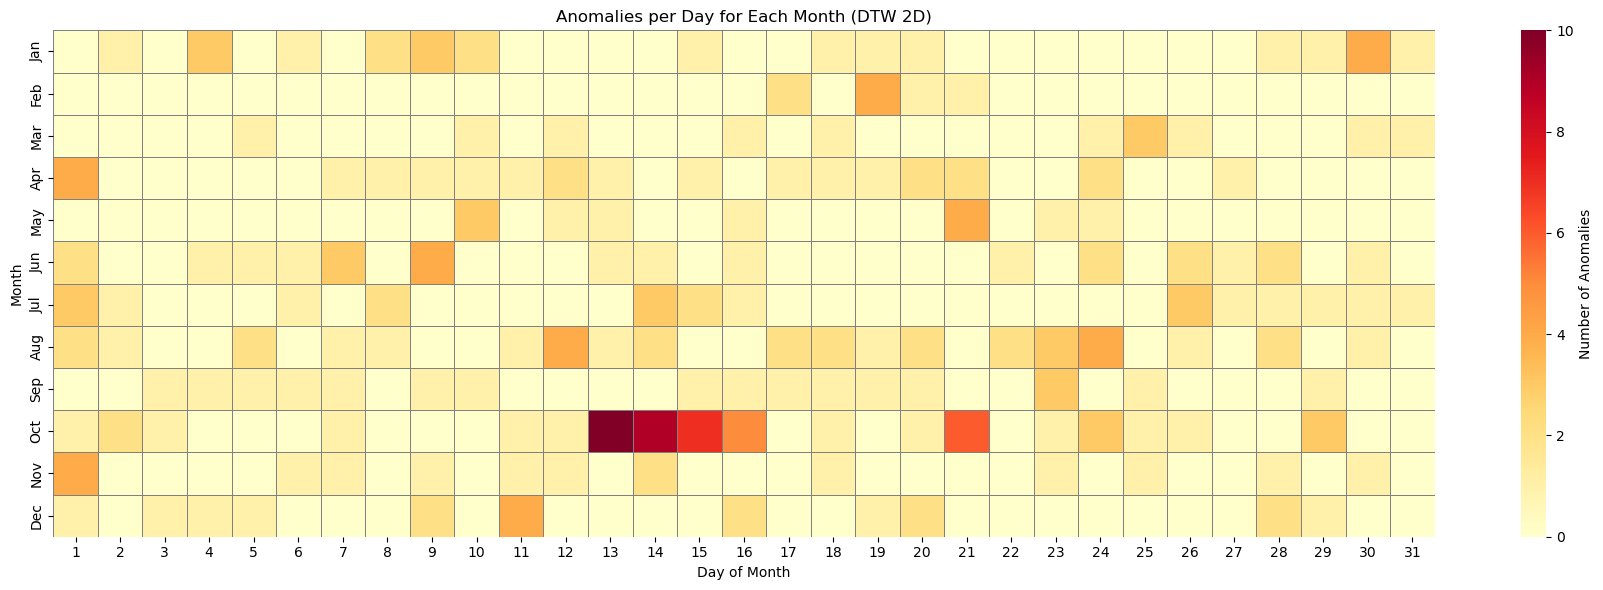

In [48]:
def plot_anomalies_per_month_day(traffic, title_suffix=""):
    dtw_2d_anomalies_per_month_day = {}
    for flight in traffic:
        month = flight.start.month
        day = flight.start.day
        key = (month, day)
        if key not in dtw_2d_anomalies_per_month_day:
            dtw_2d_anomalies_per_month_day[key] = 0
        dtw_2d_anomalies_per_month_day[key] += 1

    max_days = 31
    months = range(1, 13)
    days = range(1, max_days + 1)
    data = np.zeros((12, max_days), dtype=int)

    for (month, day), count in dtw_2d_anomalies_per_month_day.items():
        data[month - 1, day - 1] = count

    df_grid = pd.DataFrame(data, index=[calendar.month_abbr[m] for m in months], columns=range(1, max_days + 1))
    plt.figure(figsize=(18, 6))
    sns.heatmap(df_grid, cmap="YlOrRd", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Number of Anomalies'})
    plt.xlabel('Day of Month')
    plt.ylabel('Month')
    plt.title(f'Anomalies per Day for Each Month{title_suffix}')
    plt.tight_layout()
    plt.show()
    
plot_anomalies_per_month_day(dtw_2d_traffic, " (DTW 2D)")

In [26]:
abnormal_time_in_area_identifiers = [
    f"{flight.callsign}_{flight.icao24}_{flight.start:%Y%m%d%H%M%S}"
    for flight in abnormal_time_in_area_traffic
]

In [28]:
dtw_2d_anomalies_identifiers = [
    f"{flight.callsign}_{flight.icao24}_{flight.start:%Y%m%d%H%M%S}"
    for flight in dtw_2d_traffic
]

In [29]:
len(abnormal_time_in_area_identifiers), len(dtw_2d_anomalies_identifiers)

(68, 265)

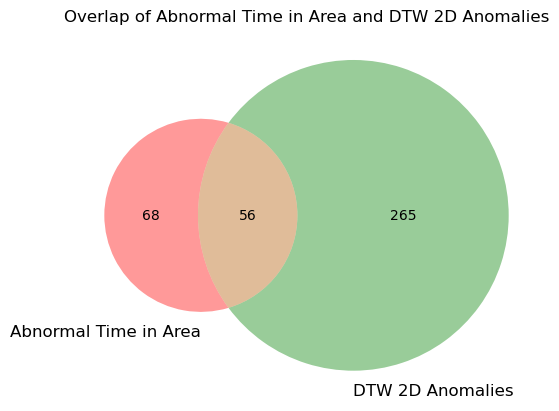

In [35]:
from matplotlib_venn import venn2

plt.figure(figsize=(6, 6))
venn2(subsets=(len(abnormal_set), len(dtw2d_set), len(common_flights)),
    set_labels=('Abnormal Time in Area', 'DTW 2D Anomalies'))
plt.title('Overlap of Abnormal Time in Area and DTW 2D Anomalies')
plt.show()


## Abnormal 3D trajectories flights

In [89]:
dtw_3d_folder = "dtw_3d"
dtw_3d_traffic = load_dtw_flights_from_folder(dtw_3d_folder)

In [68]:
dtw_3d_traffic

icao24 callsign  count
0  461e1f  FIN1143   7107
1  489329  LOT3904   6109
2  48ae01   LOT2LY   5473
3  48ad81   LOT774   5398
4  8964d3  FDB1829   4152
5  48ada6   LOT3VM   3868
6  461e14  FIN1143   3823
7  489329   LOT5MG   3476
8  48932b   LOT3VT   3371
9  48ada5   LOT3VM   3143

In [69]:
print(f"Number of flights: {len(dtw_3d_traffic)}")

Number of flights: 304


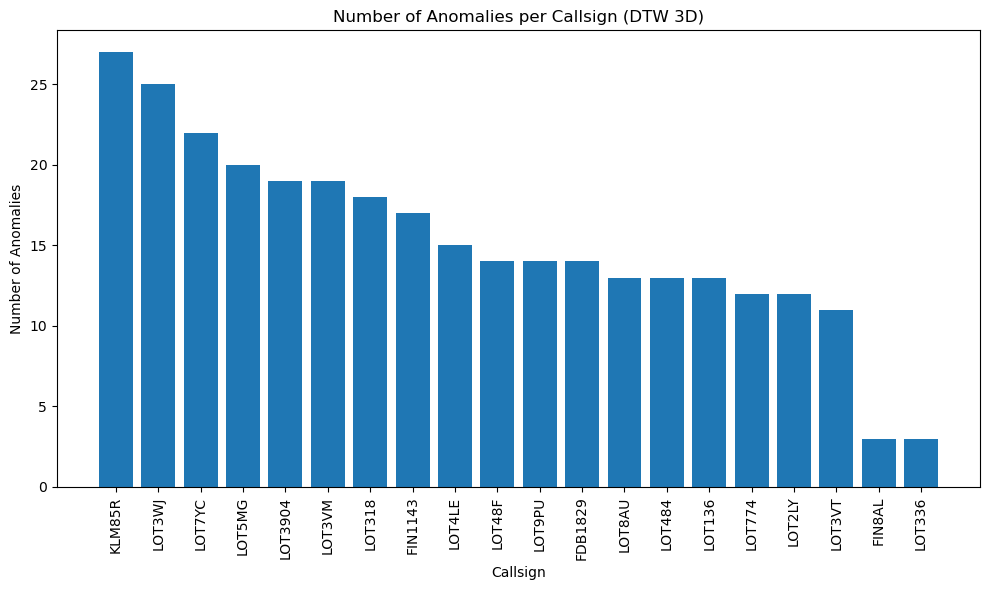

In [70]:
plot_anomalies_per_callsign(dtw_3d_traffic, " (DTW 3D)")

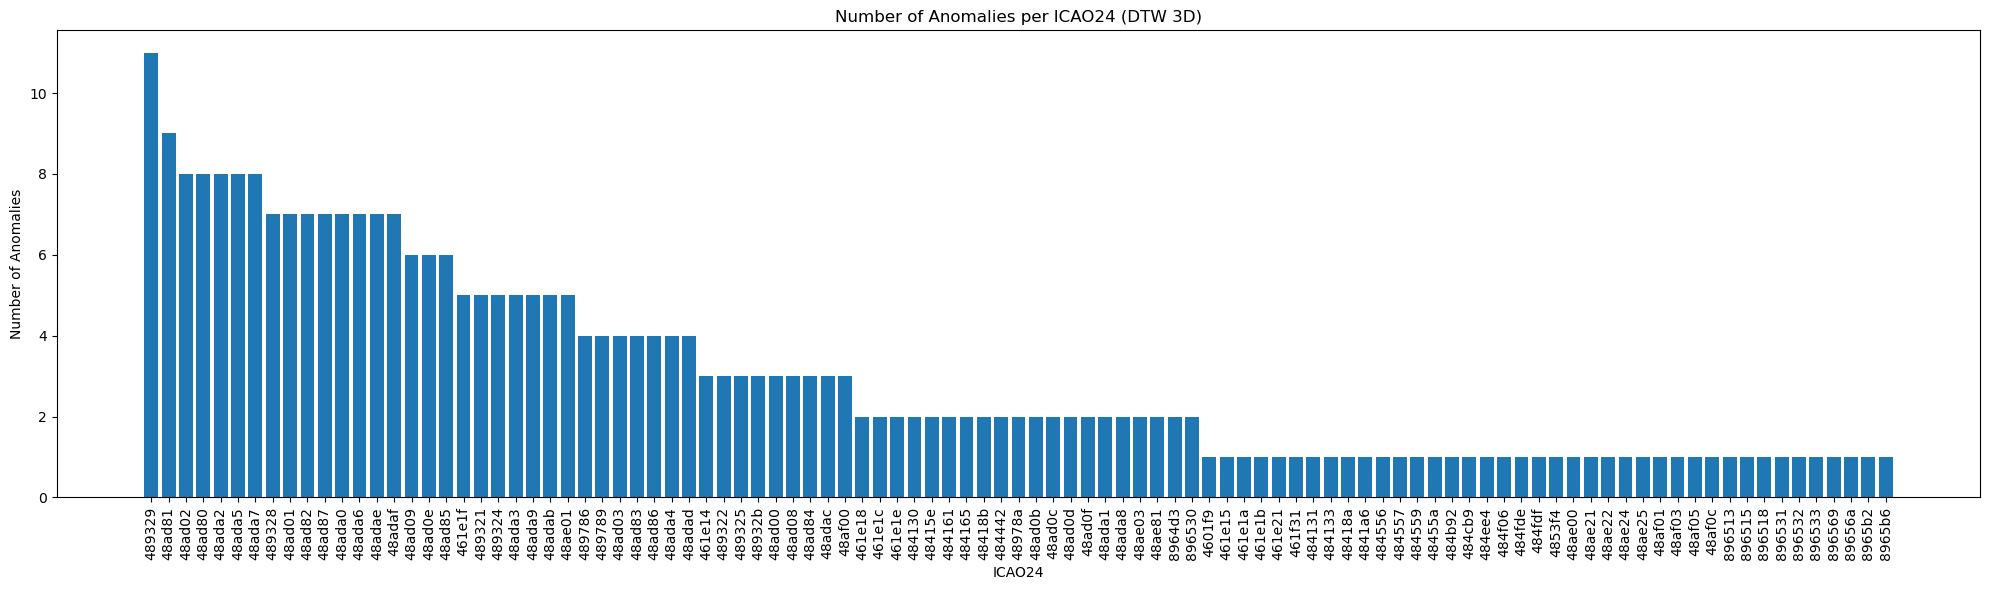

In [71]:
plot_anomalies_per_icao24(dtw_3d_traffic, " (DTW 3D)")

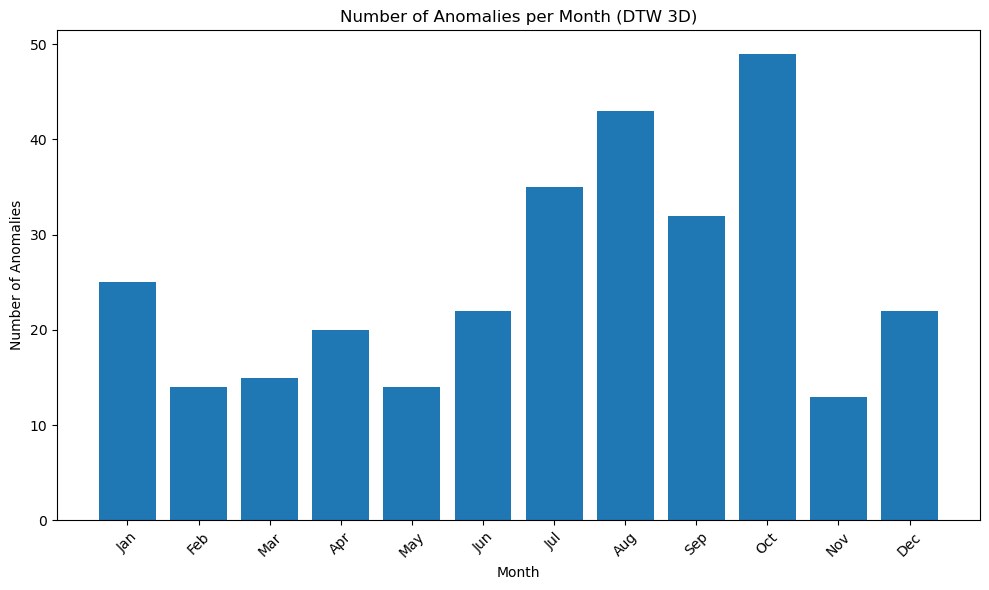

In [72]:
plot_anomalies_per_month(dtw_3d_traffic, " (DTW 3D)")

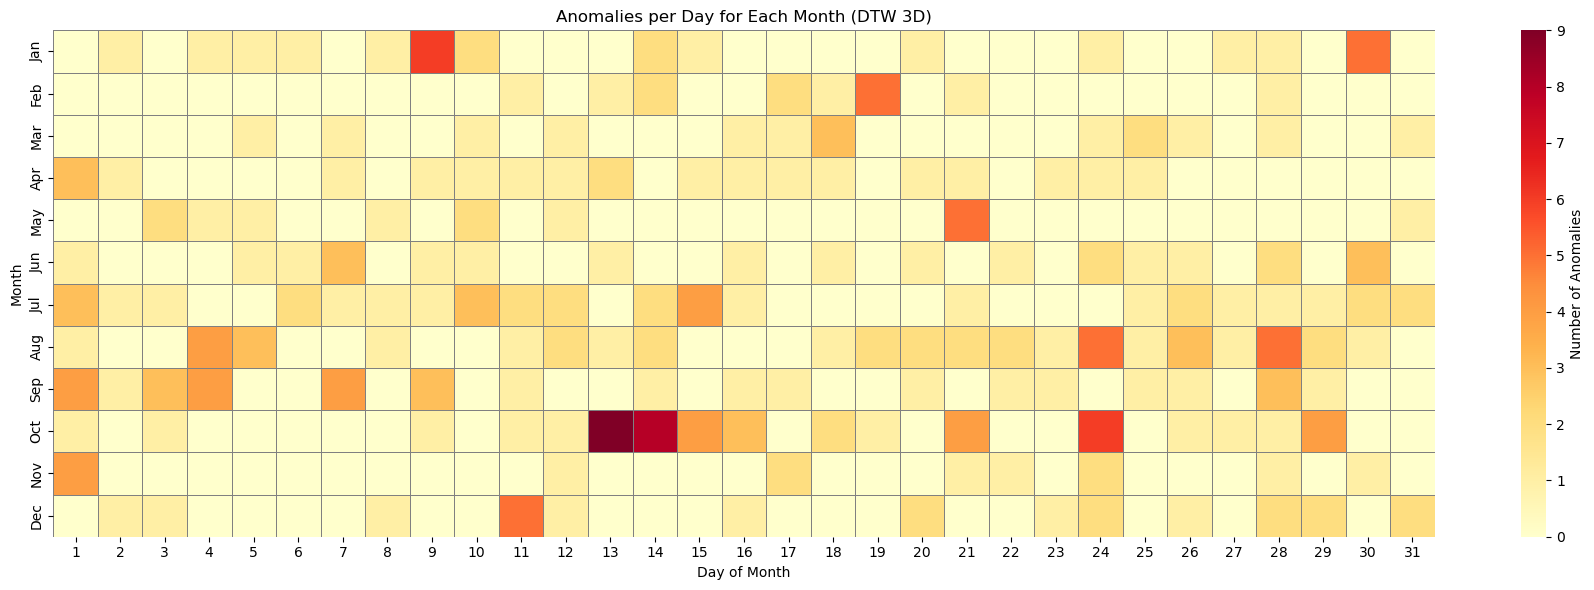

In [73]:
plot_anomalies_per_month_day(dtw_3d_traffic, " (DTW 3D)")

In [74]:
dtw_3d_anomalies_identifiers = [
    f"{flight.callsign}_{flight.icao24}_{flight.start:%Y%m%d%H%M%S}"
    for flight in dtw_3d_traffic
]
common_flights = set(dtw_3d_anomalies_identifiers) & set(dtw_2d_anomalies_identifiers)

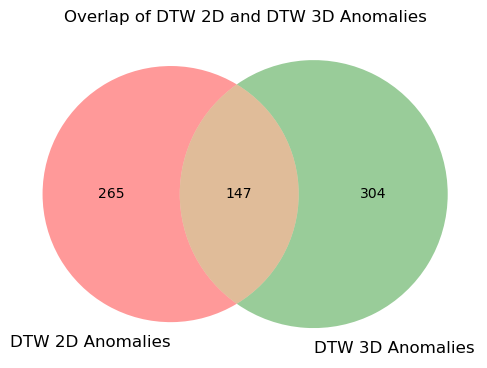

In [75]:
dtw2d_set = set(dtw_2d_anomalies_identifiers)
dtw3d_set = set(dtw_3d_anomalies_identifiers)
common_2d_3d = dtw2d_set & dtw3d_set

plt.figure(figsize=(6, 6))
venn2(subsets=(len(dtw2d_set), len(dtw3d_set), len(common_2d_3d)),
    set_labels=('DTW 2D Anomalies', 'DTW 3D Anomalies'))
plt.title('Overlap of DTW 2D and DTW 3D Anomalies')
plt.show()

## Abnormal all features trajectories

In [76]:
dtw_all_folder = "dtw_all"
dtw_all_traffic = load_dtw_flights_from_folder(dtw_all_folder)

In [77]:
dtw_all_traffic

icao24 callsign  count
0  461e1f  FIN1143   4814
1  48ae01   LOT2LY   4602
2  48ad81   LOT774   4465
3  489328   LOT3VT   4140
4  489329   LOT3VT   3663
5  489324   LOT3VT   3508
6  489329   LOT5MG   3476
7  48932b   LOT3VT   3371
8  48adab   LOT136   3155
9  48ada5   LOT3VM   3143

In [78]:
print(f"Number of flights: {len(dtw_all_traffic)}")

Number of flights: 280


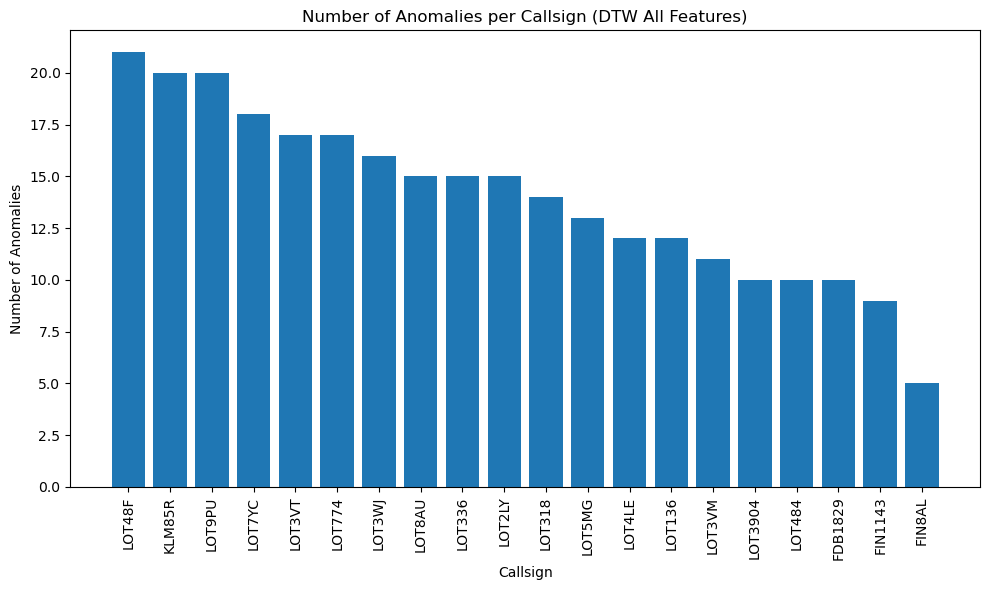

In [79]:
plot_anomalies_per_callsign(dtw_all_traffic, " (DTW All Features)")

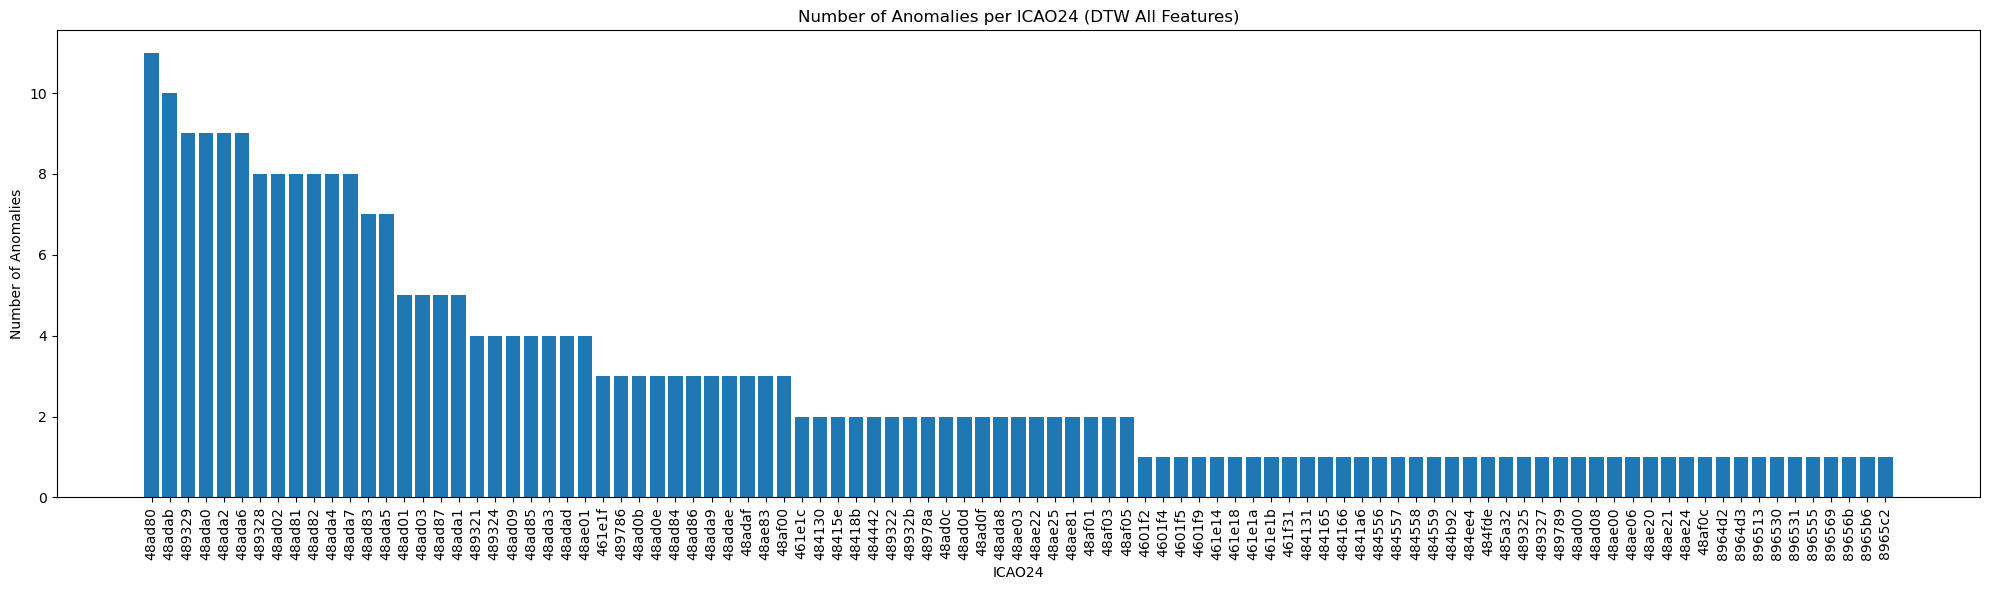

In [80]:
plot_anomalies_per_icao24(dtw_all_traffic, " (DTW All Features)")

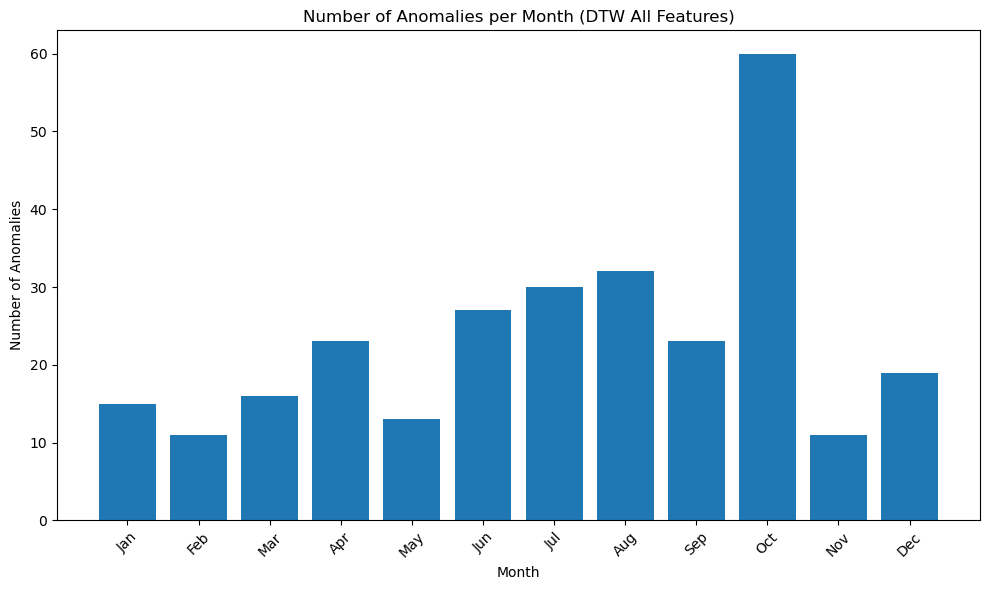

In [81]:
plot_anomalies_per_month(dtw_all_traffic, " (DTW All Features)")

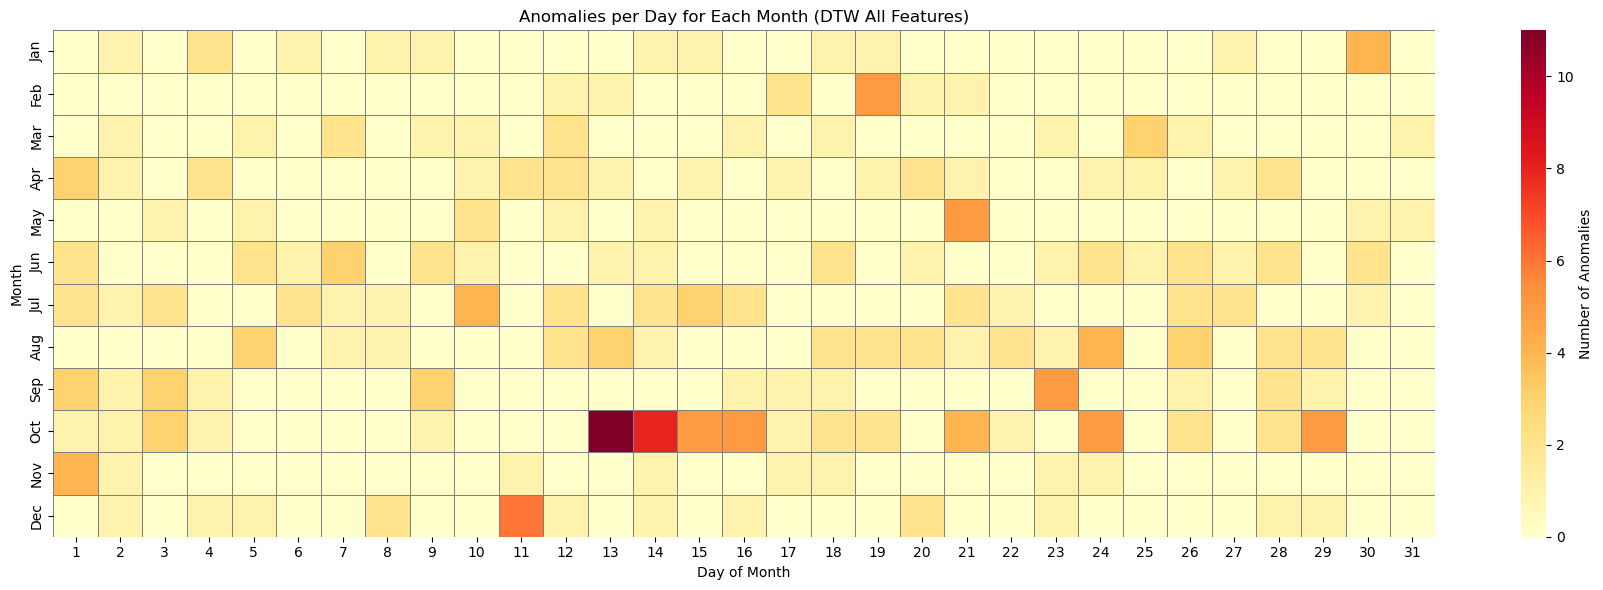

In [82]:
plot_anomalies_per_month_day(dtw_all_traffic, " (DTW All Features)")

## Anormal groundspeed and vertical rate flights

In [83]:
dtw_groundspeed_vertical_folder = "dtw_groundspeed_vertical"
dtw_groundspeed_vertical_traffic = load_dtw_flights_from_folder(dtw_groundspeed_vertical_folder)
dtw_groundspeed_vertical_traffic

icao24 callsign  count
0  489324   LOT3VT   6946
1  48932b   LOT3VT   5780
2  489328   LOT3VT   5258
3  489329   LOT5MG   4016
4  489329  LOT3904   3893
5  489329   LOT3VT   3781
6  489321   LOT5MG   3627
7  48ad81   LOT774   3469
8  48ad82   LOT774   3360
9  48ada5   LOT3VM   3143

In [85]:
print(f"Number of flights: {len(dtw_groundspeed_vertical_traffic)}")

Number of flights: 249


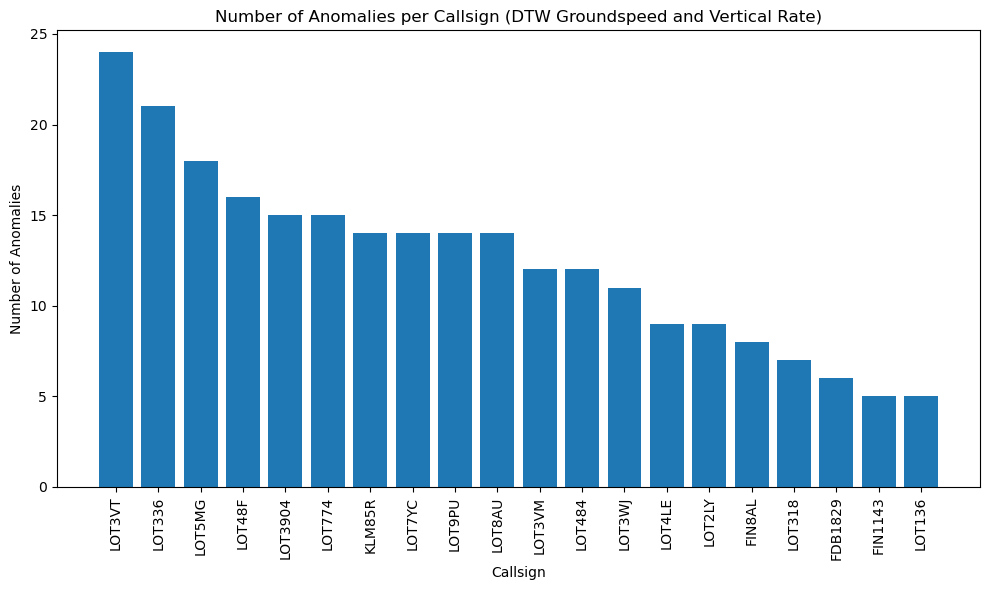

In [87]:
plot_anomalies_per_callsign(dtw_groundspeed_vertical_traffic, " (DTW Groundspeed and Vertical Rate)")

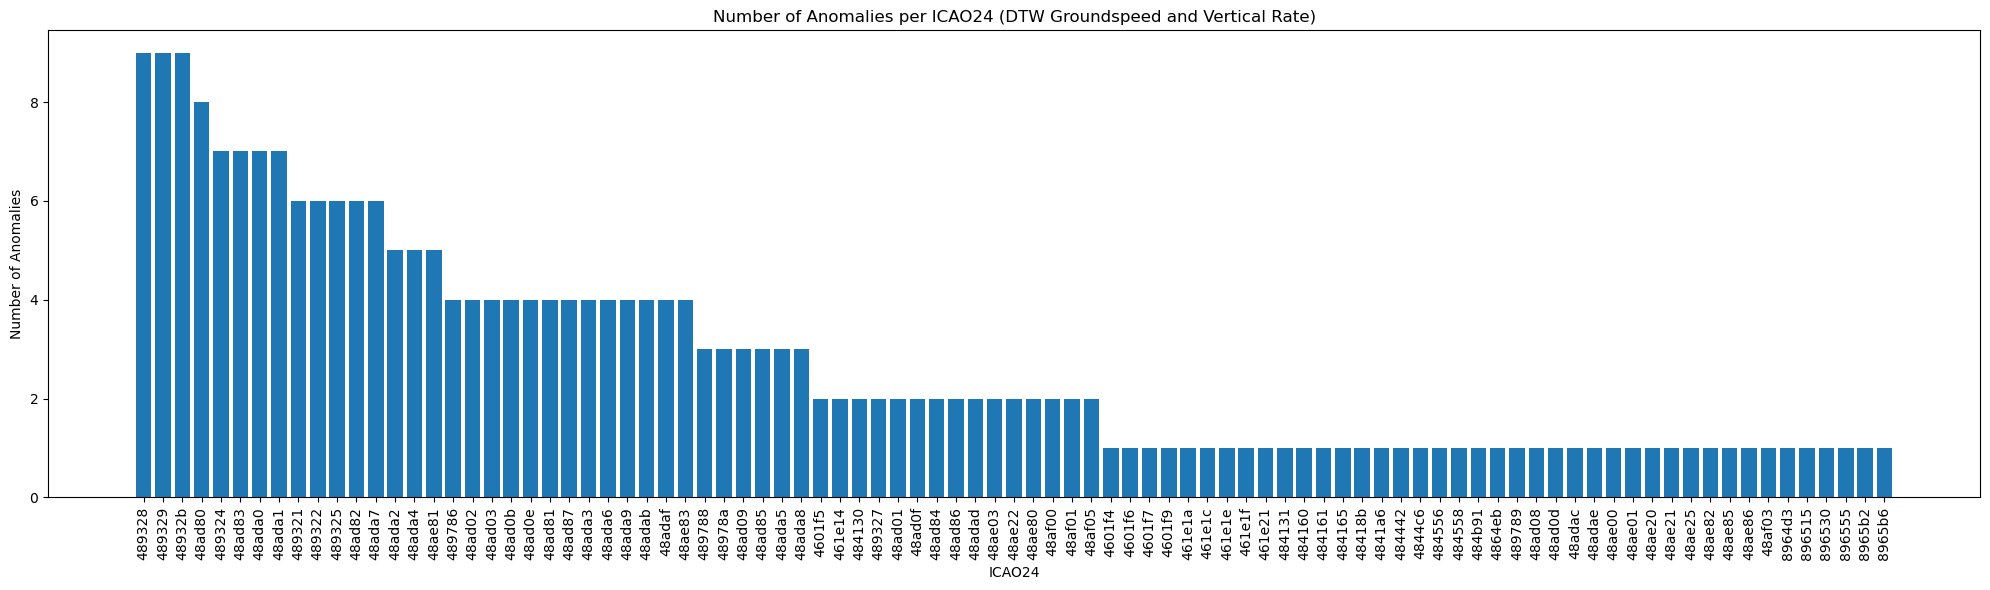

In [89]:
plot_anomalies_per_icao24(dtw_groundspeed_vertical_traffic, " (DTW Groundspeed and Vertical Rate)")

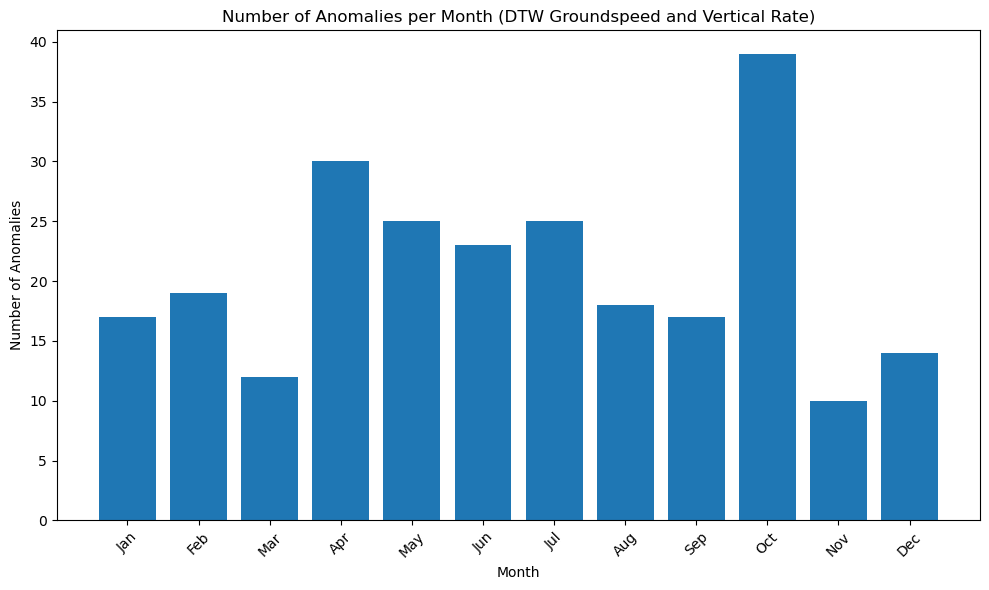

In [90]:
plot_anomalies_per_month(dtw_groundspeed_vertical_traffic, " (DTW Groundspeed and Vertical Rate)")

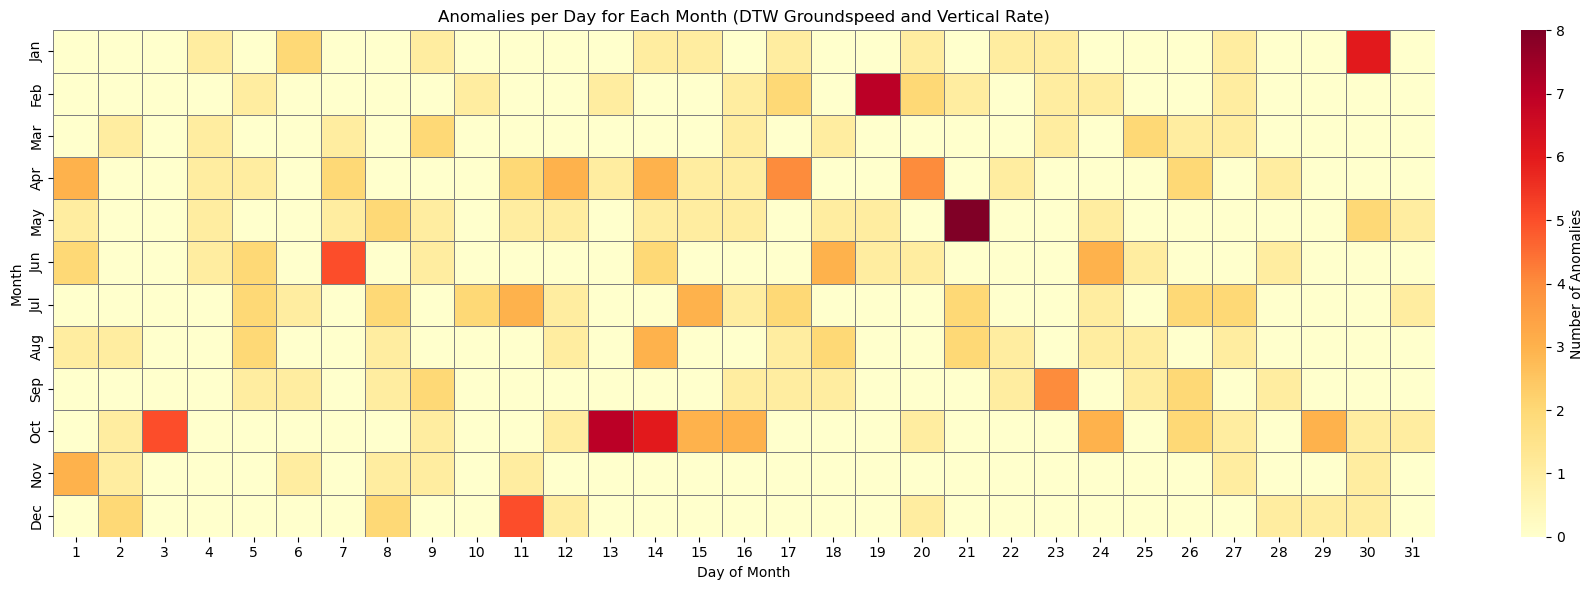

In [91]:
plot_anomalies_per_month_day(dtw_groundspeed_vertical_traffic, " (DTW Groundspeed and Vertical Rate)")

## Specific Total Energy (STE) flights

In [66]:
ste_folder = "specific_total_energy"
ste_traffic = load_dtw_flights_from_folder(ste_folder)
ste_traffic

icao24 callsign  count
0  48ada7   LOT136   1210
1  48ad81   LOT774   1171
2  48adab   LOT136   1158
3  489329   LOT5MG   1091
4  48ad87   LOT8AU   1015
5  48ada7   LOT9PU   1002
6  461e1d  FIN1143    931
7  48ae01   LOT2LY    857
8  48ada2   LOT48F    850
9  489325   LOT3VM    798

In [93]:
print(f"Number of flights: {len(ste_traffic)}")

Number of flights: 346


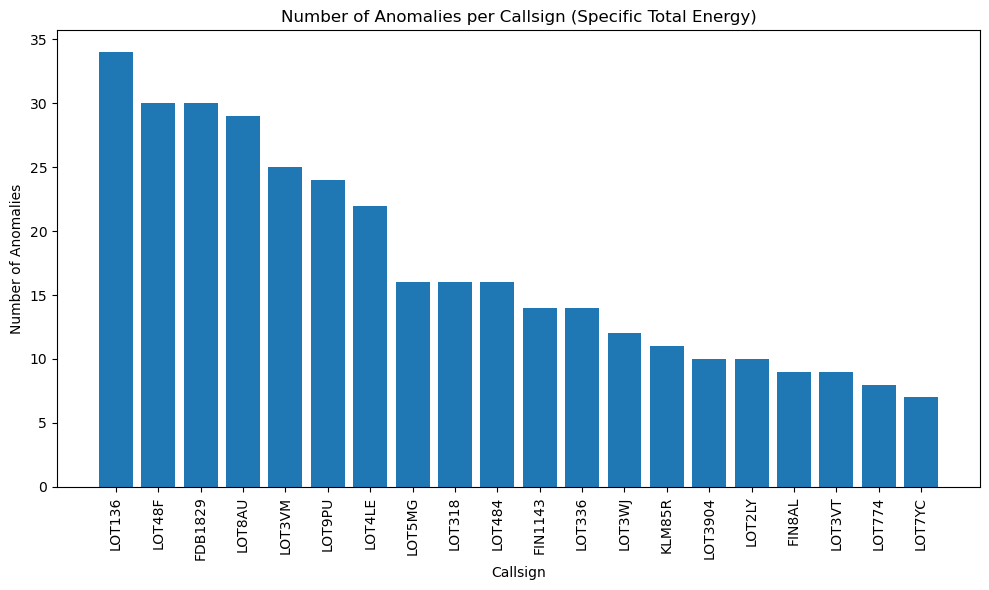

In [94]:
plot_anomalies_per_callsign(ste_traffic, " (Specific Total Energy)")

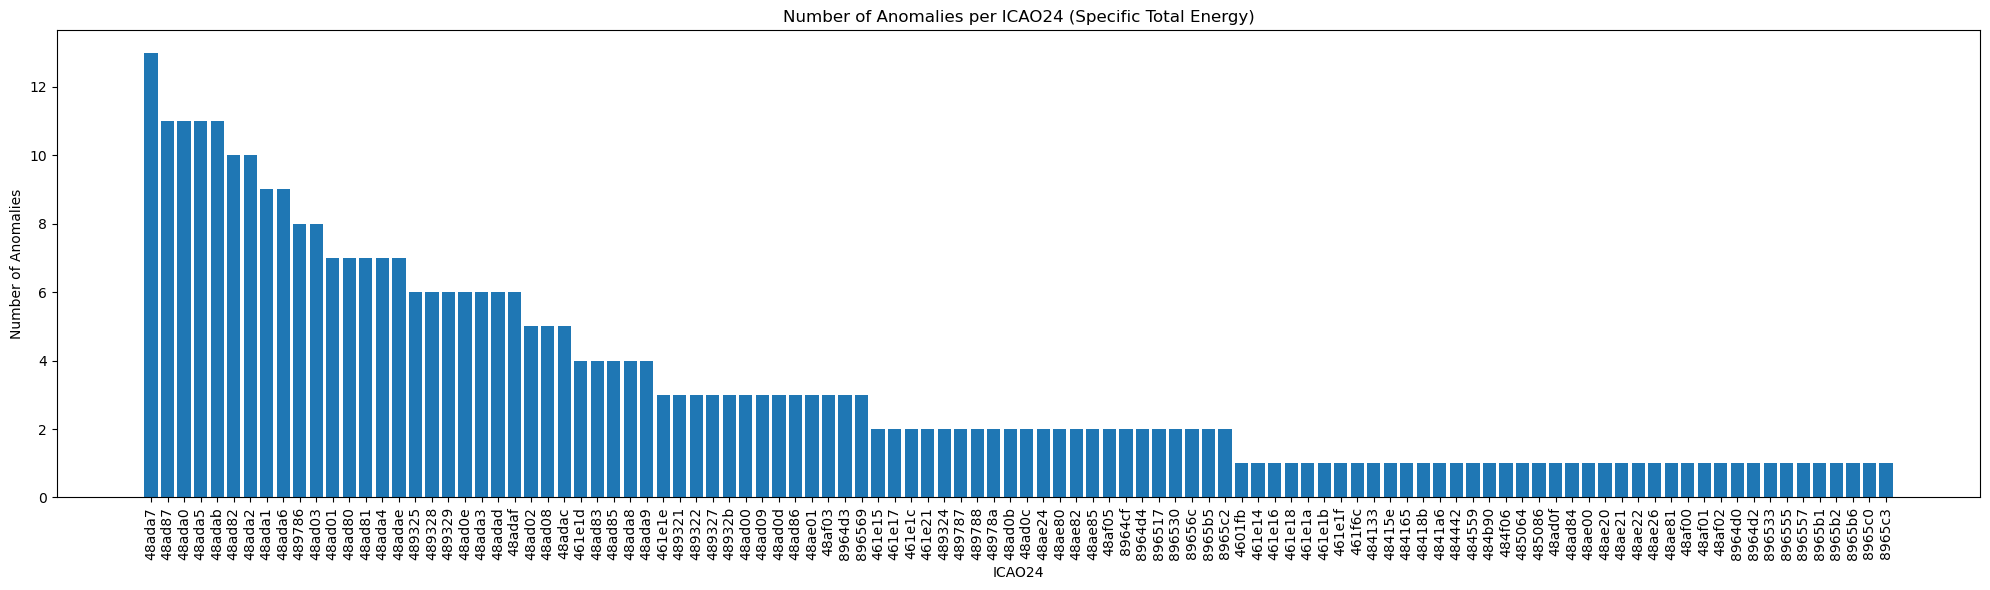

In [95]:
plot_anomalies_per_icao24(ste_traffic, " (Specific Total Energy)")

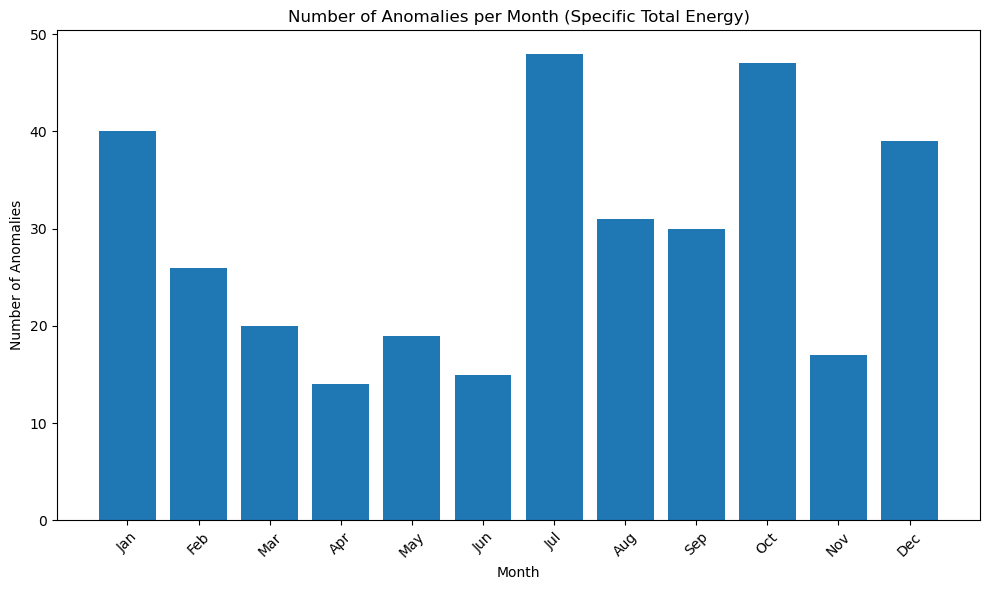

In [96]:
plot_anomalies_per_month(ste_traffic, " (Specific Total Energy)")

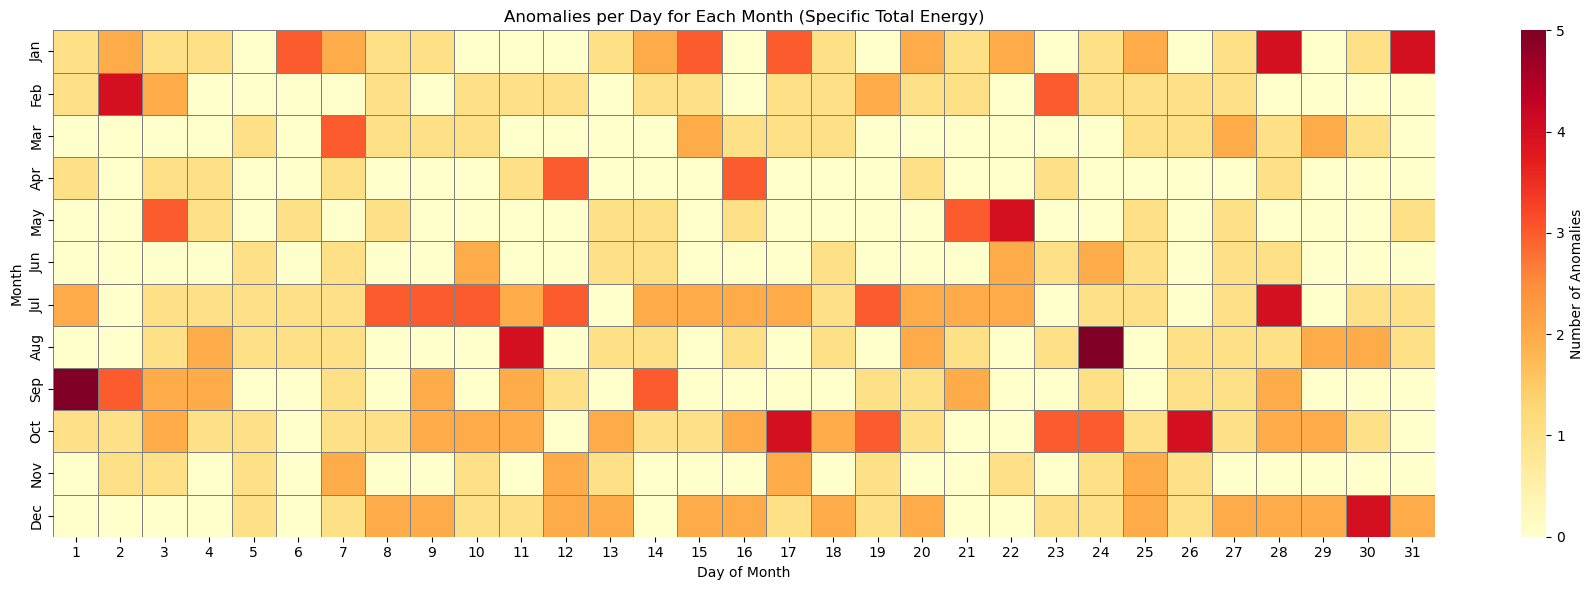

In [97]:
plot_anomalies_per_month_day(ste_traffic, " (Specific Total Energy)")

## Potential Flight Path Angle (PFPA) flights

In [99]:
pfpa_folder = "potential_flight_path_angle_anomalies"
pfpa_traffic = load_dtw_flights_from_folder(pfpa_folder)
pfpa_traffic

icao24 callsign  count
0  461e1c  FIN1143   2247
1  461e21  FIN1143   1838
2  461e1b   FIN8AL   1576
3  461e1a   FIN8AL   1533
4  461e1d  FIN1143   1211
5  48ad87   LOT8AU   1094
6  48ae25   LOT2LY   1084
7  461e18  FIN1143   1072
8  48ad03   LOT8AU    988
9  4601f2   FIN8AL    825

In [100]:
print(f"Number of flights: {len(pfpa_traffic)}")

Number of flights: 332


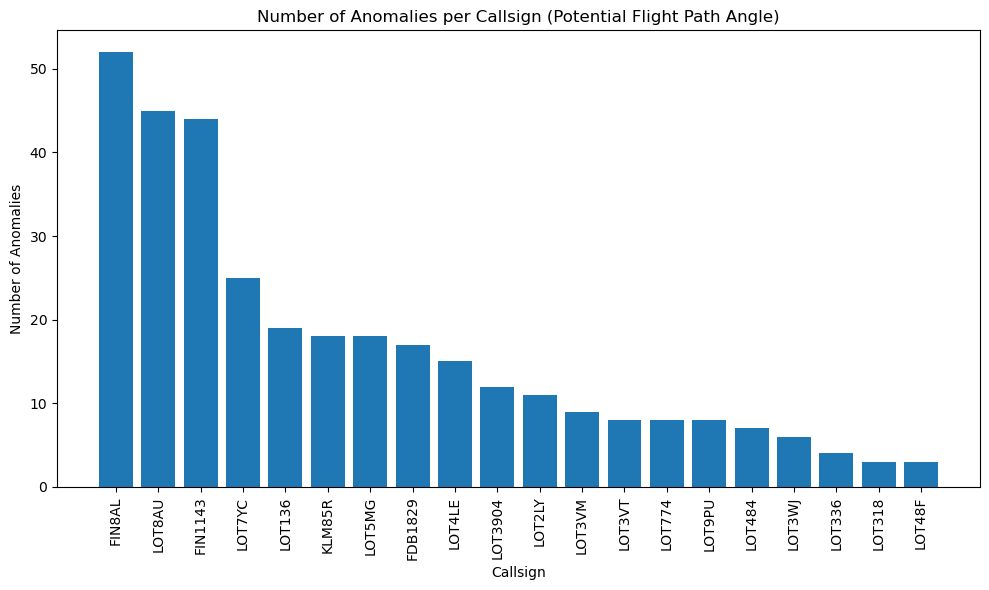

In [101]:
plot_anomalies_per_callsign(pfpa_traffic, " (Potential Flight Path Angle)")

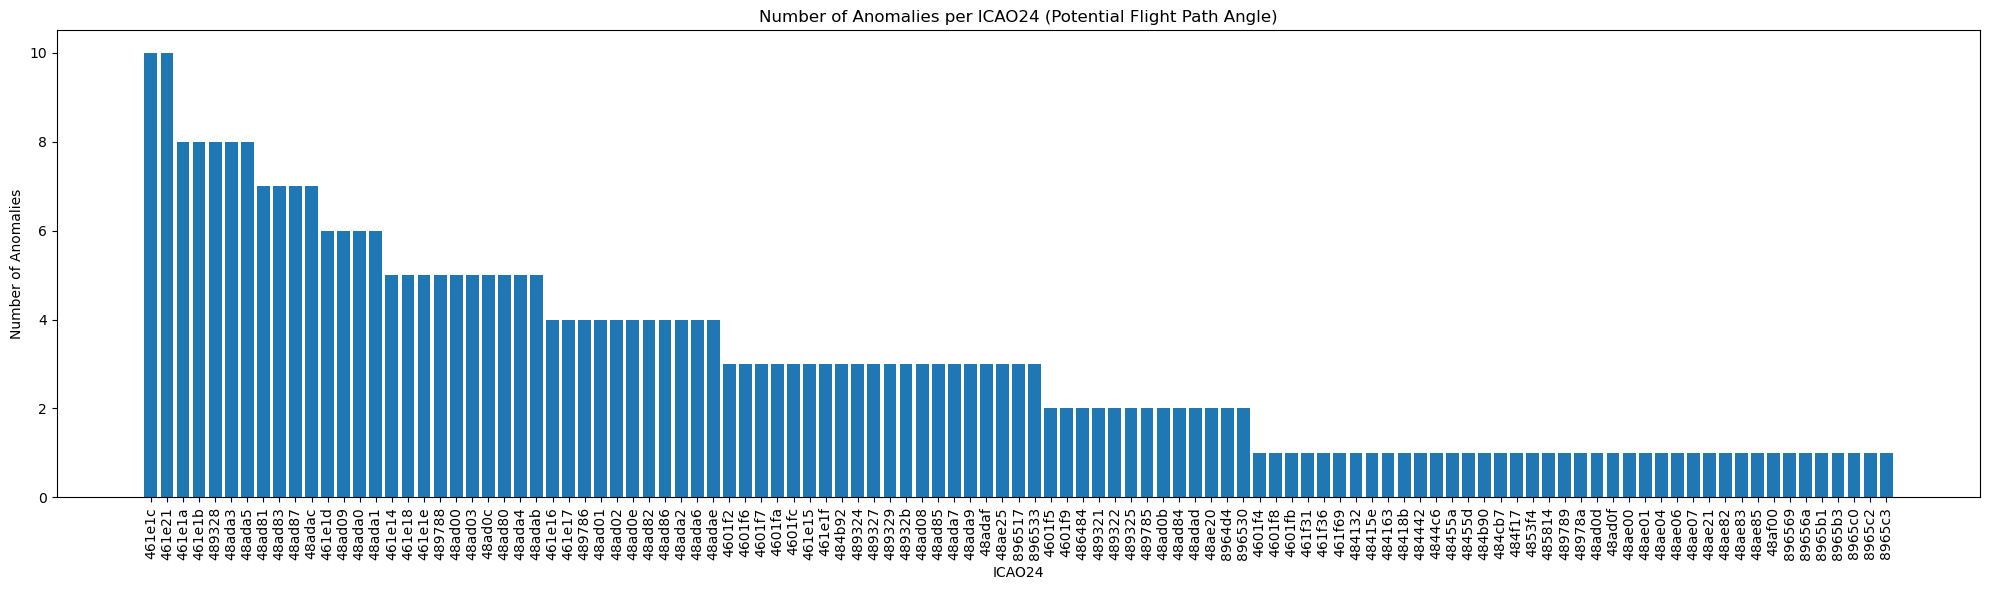

In [102]:
plot_anomalies_per_icao24(pfpa_traffic, " (Potential Flight Path Angle)")

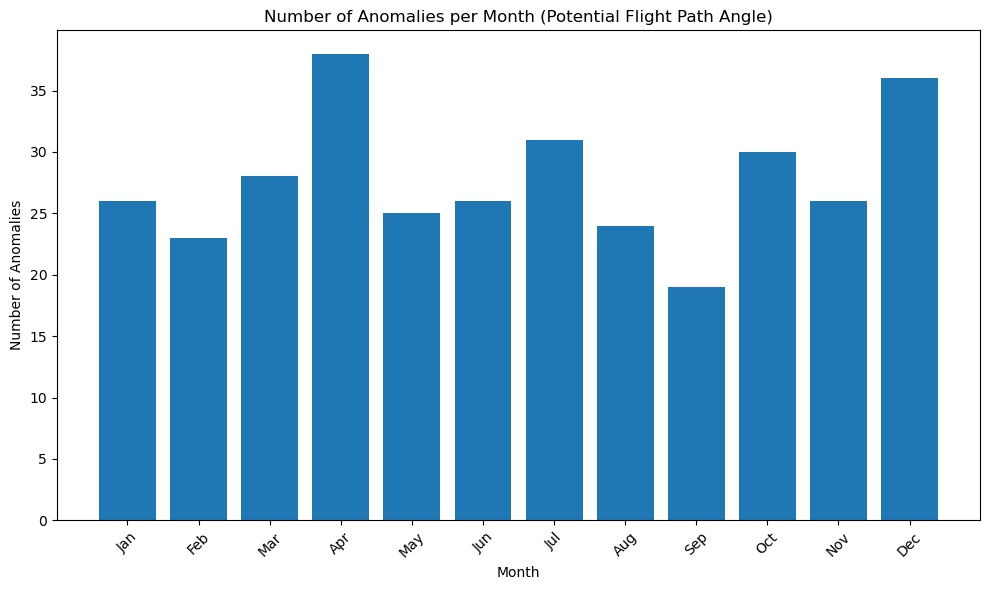

In [103]:
plot_anomalies_per_month(pfpa_traffic, " (Potential Flight Path Angle)")

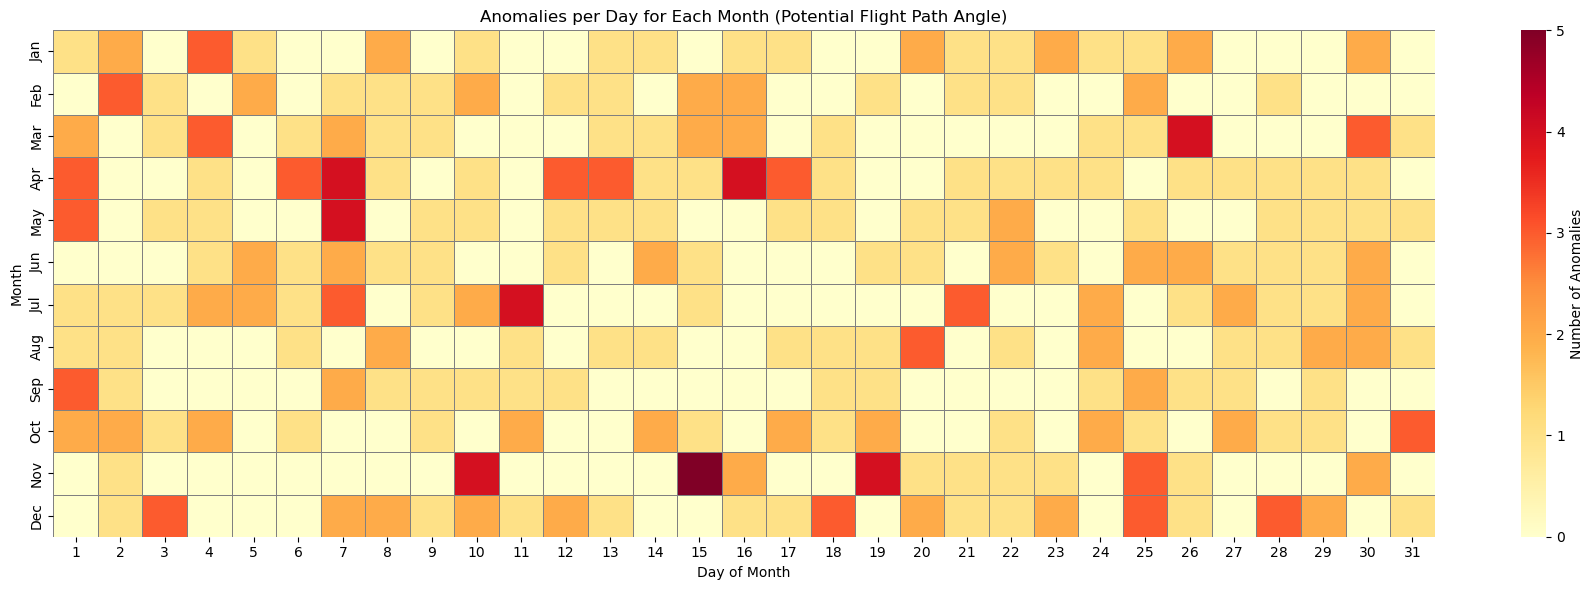

In [104]:
plot_anomalies_per_month_day(pfpa_traffic, " (Potential Flight Path Angle)")

# Comparison

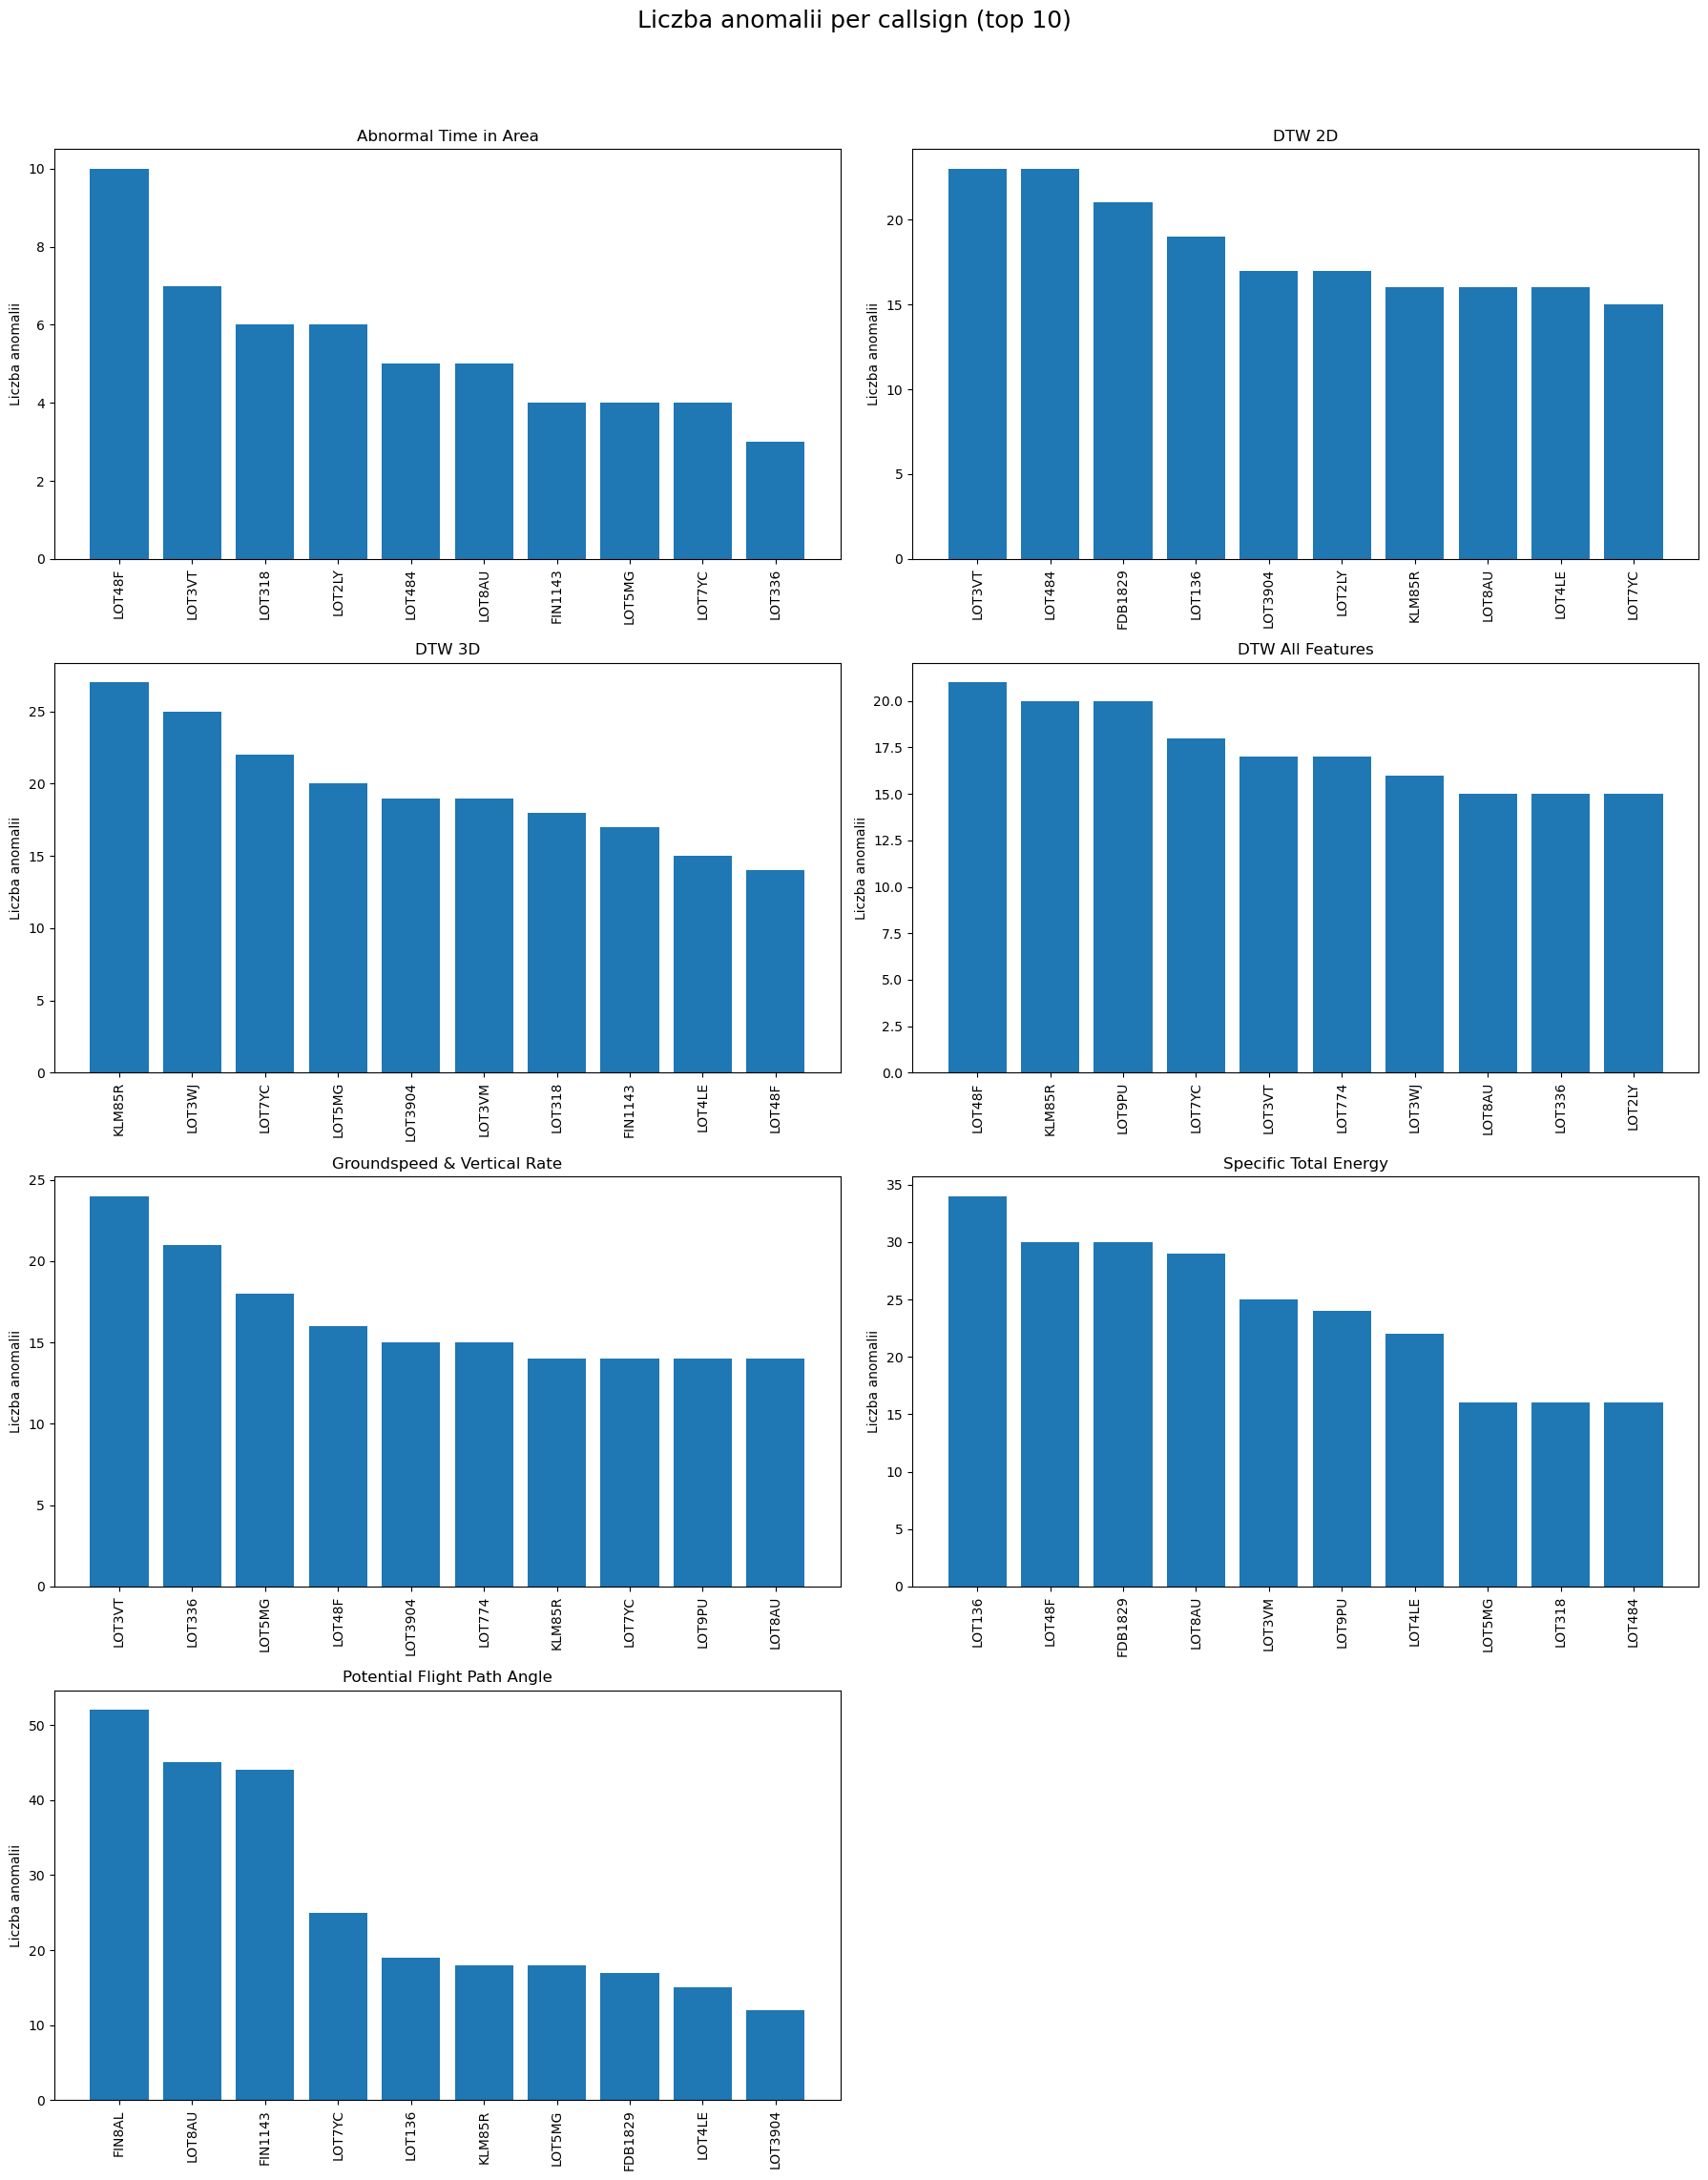

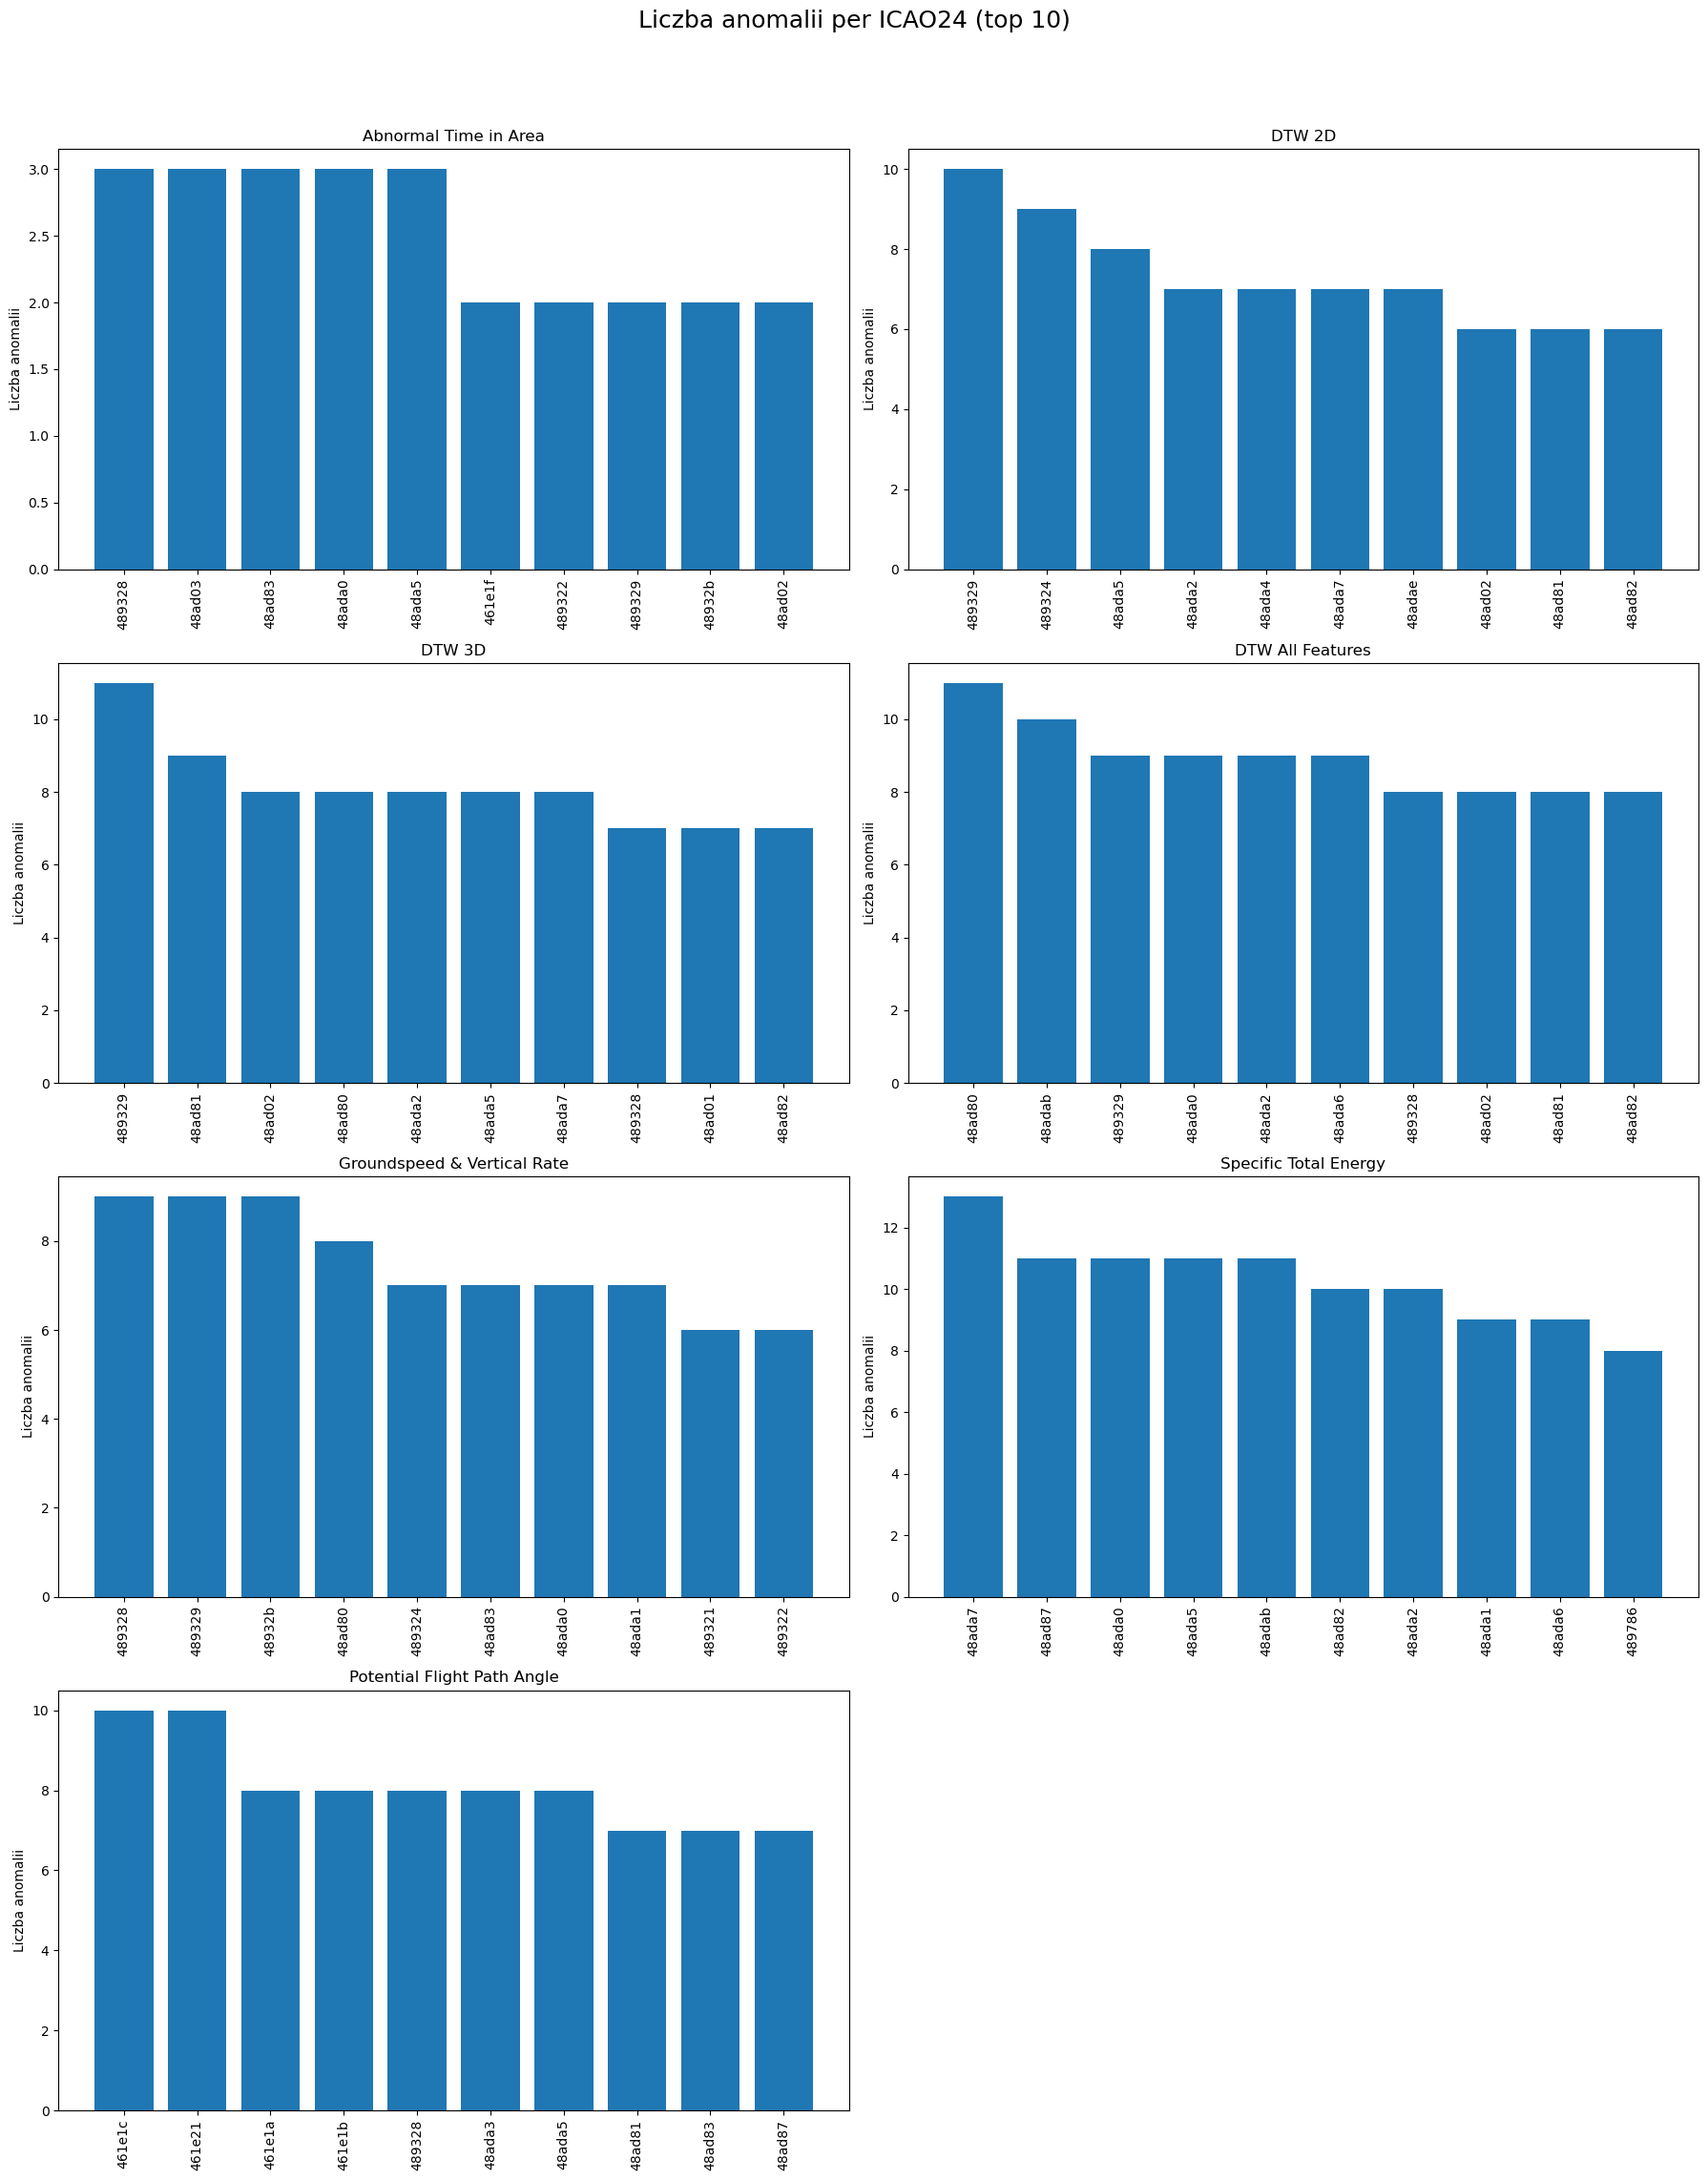

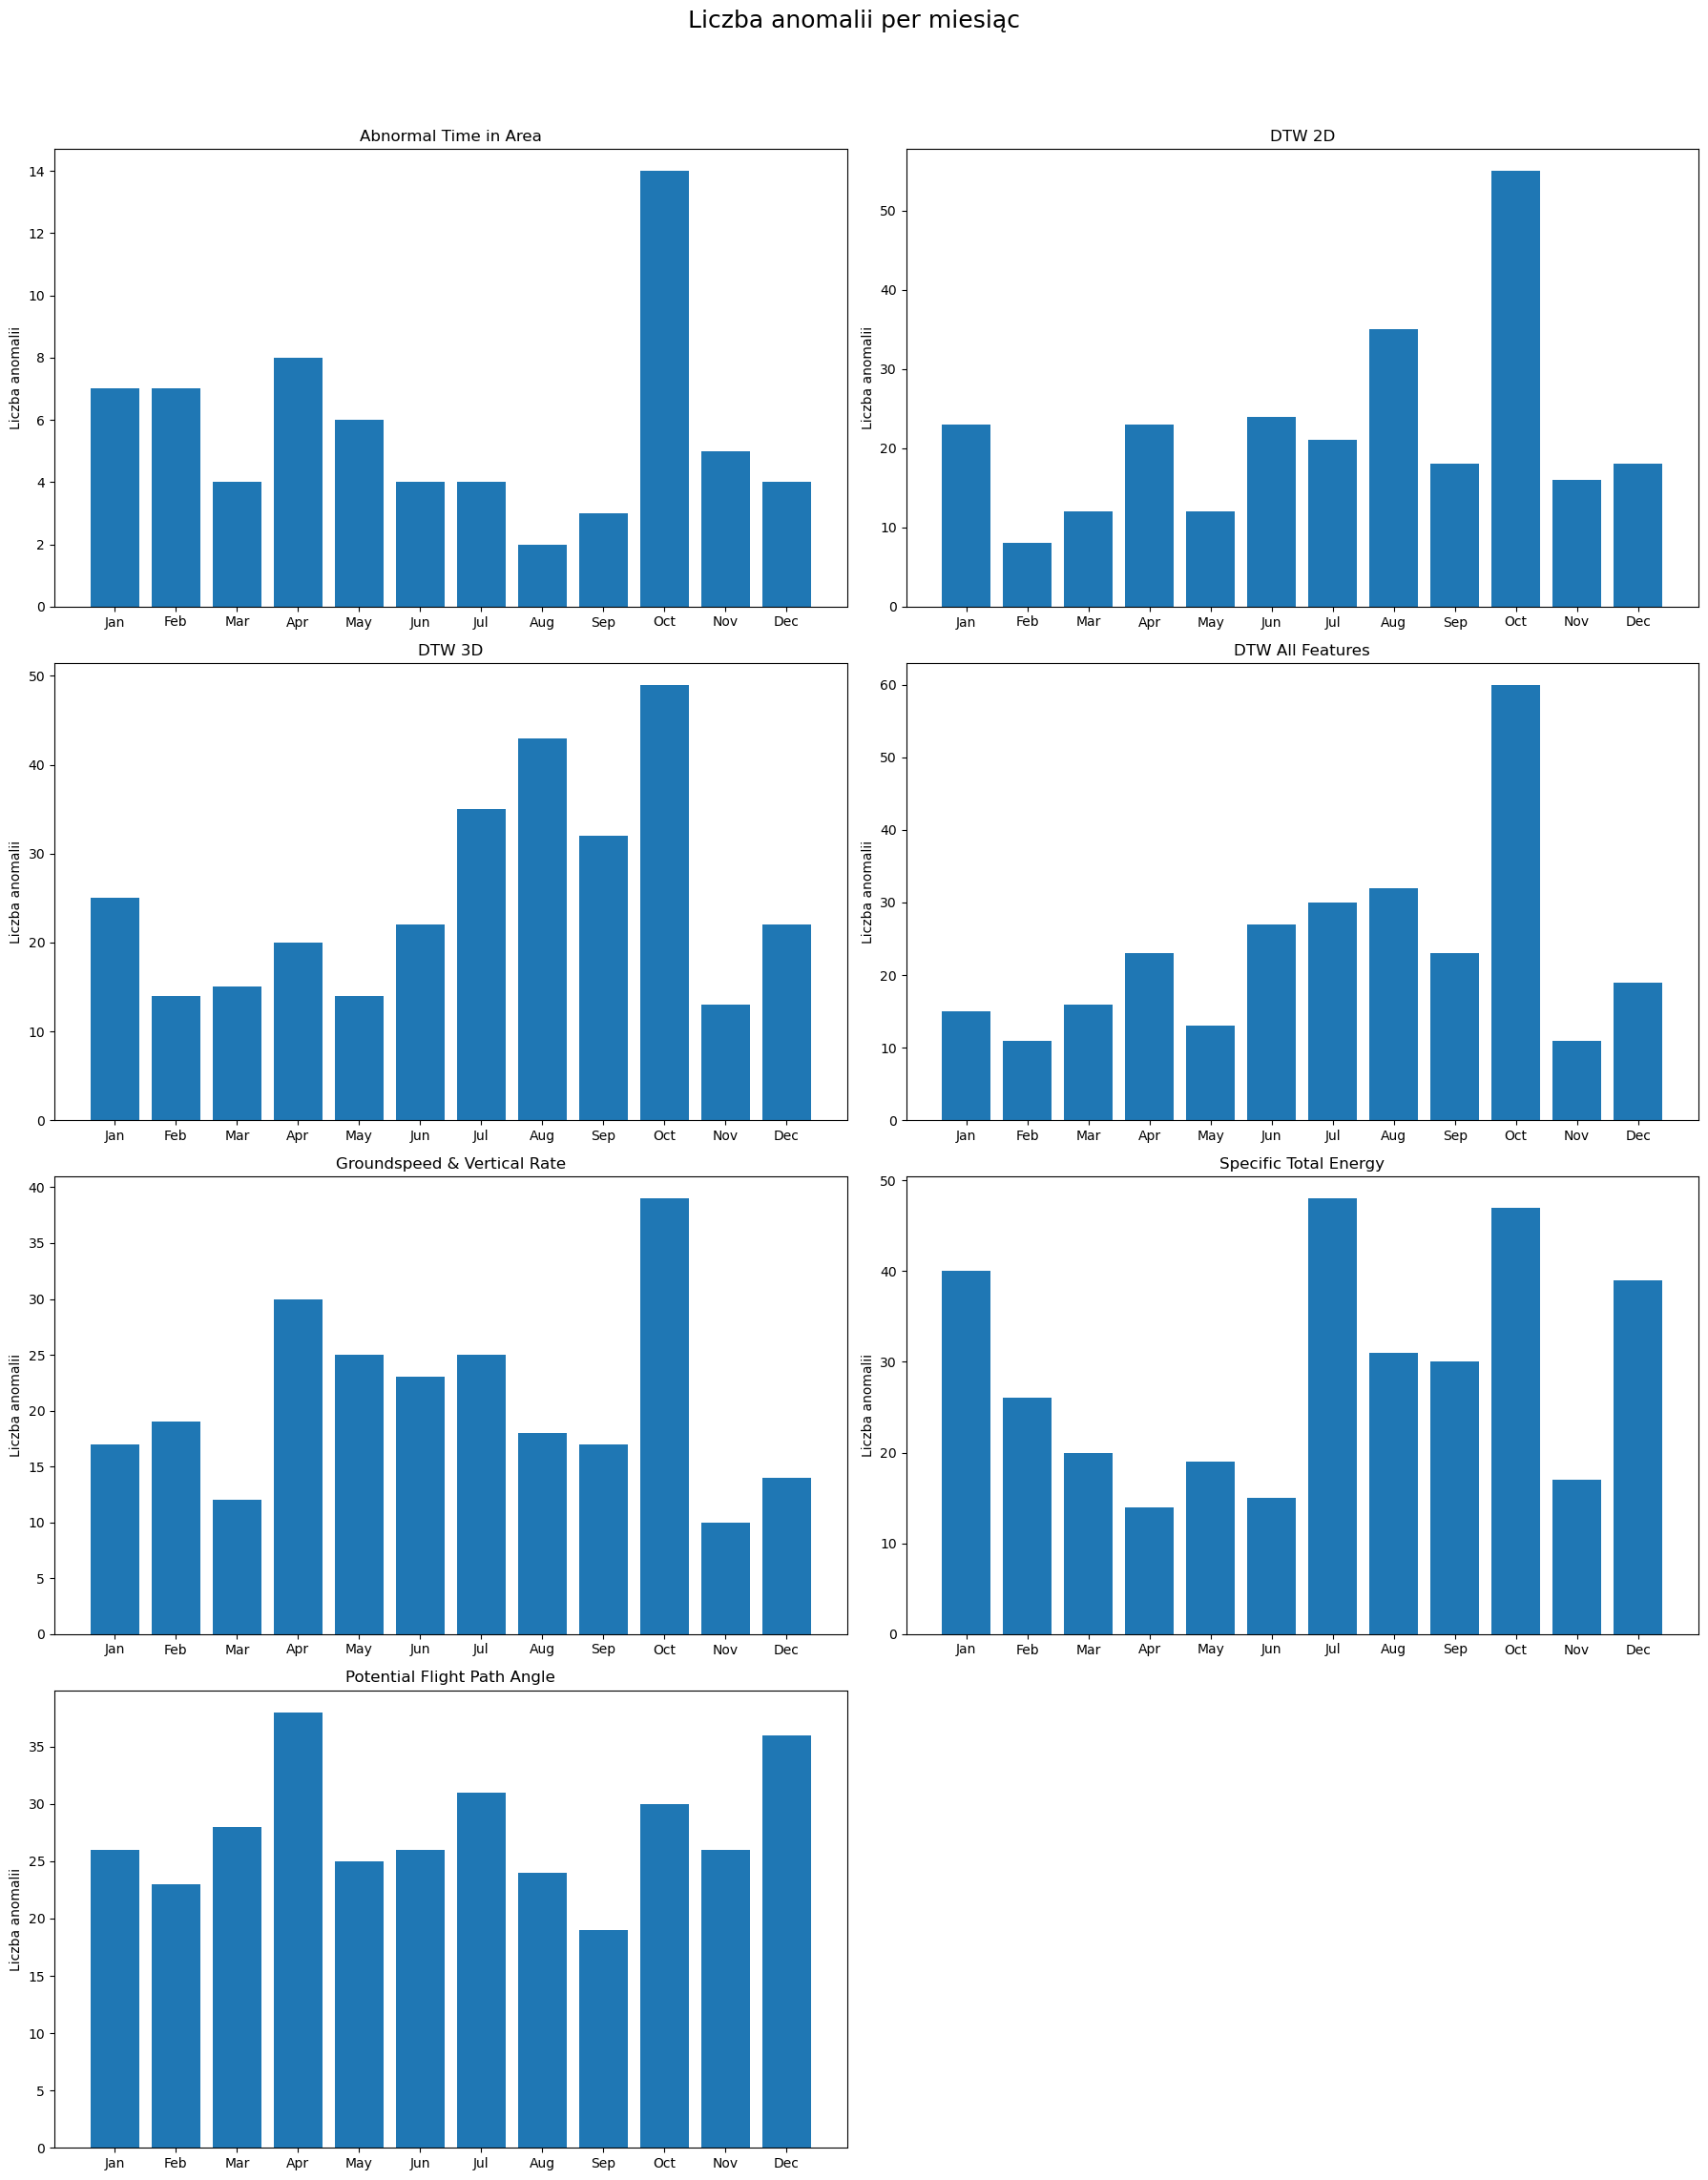

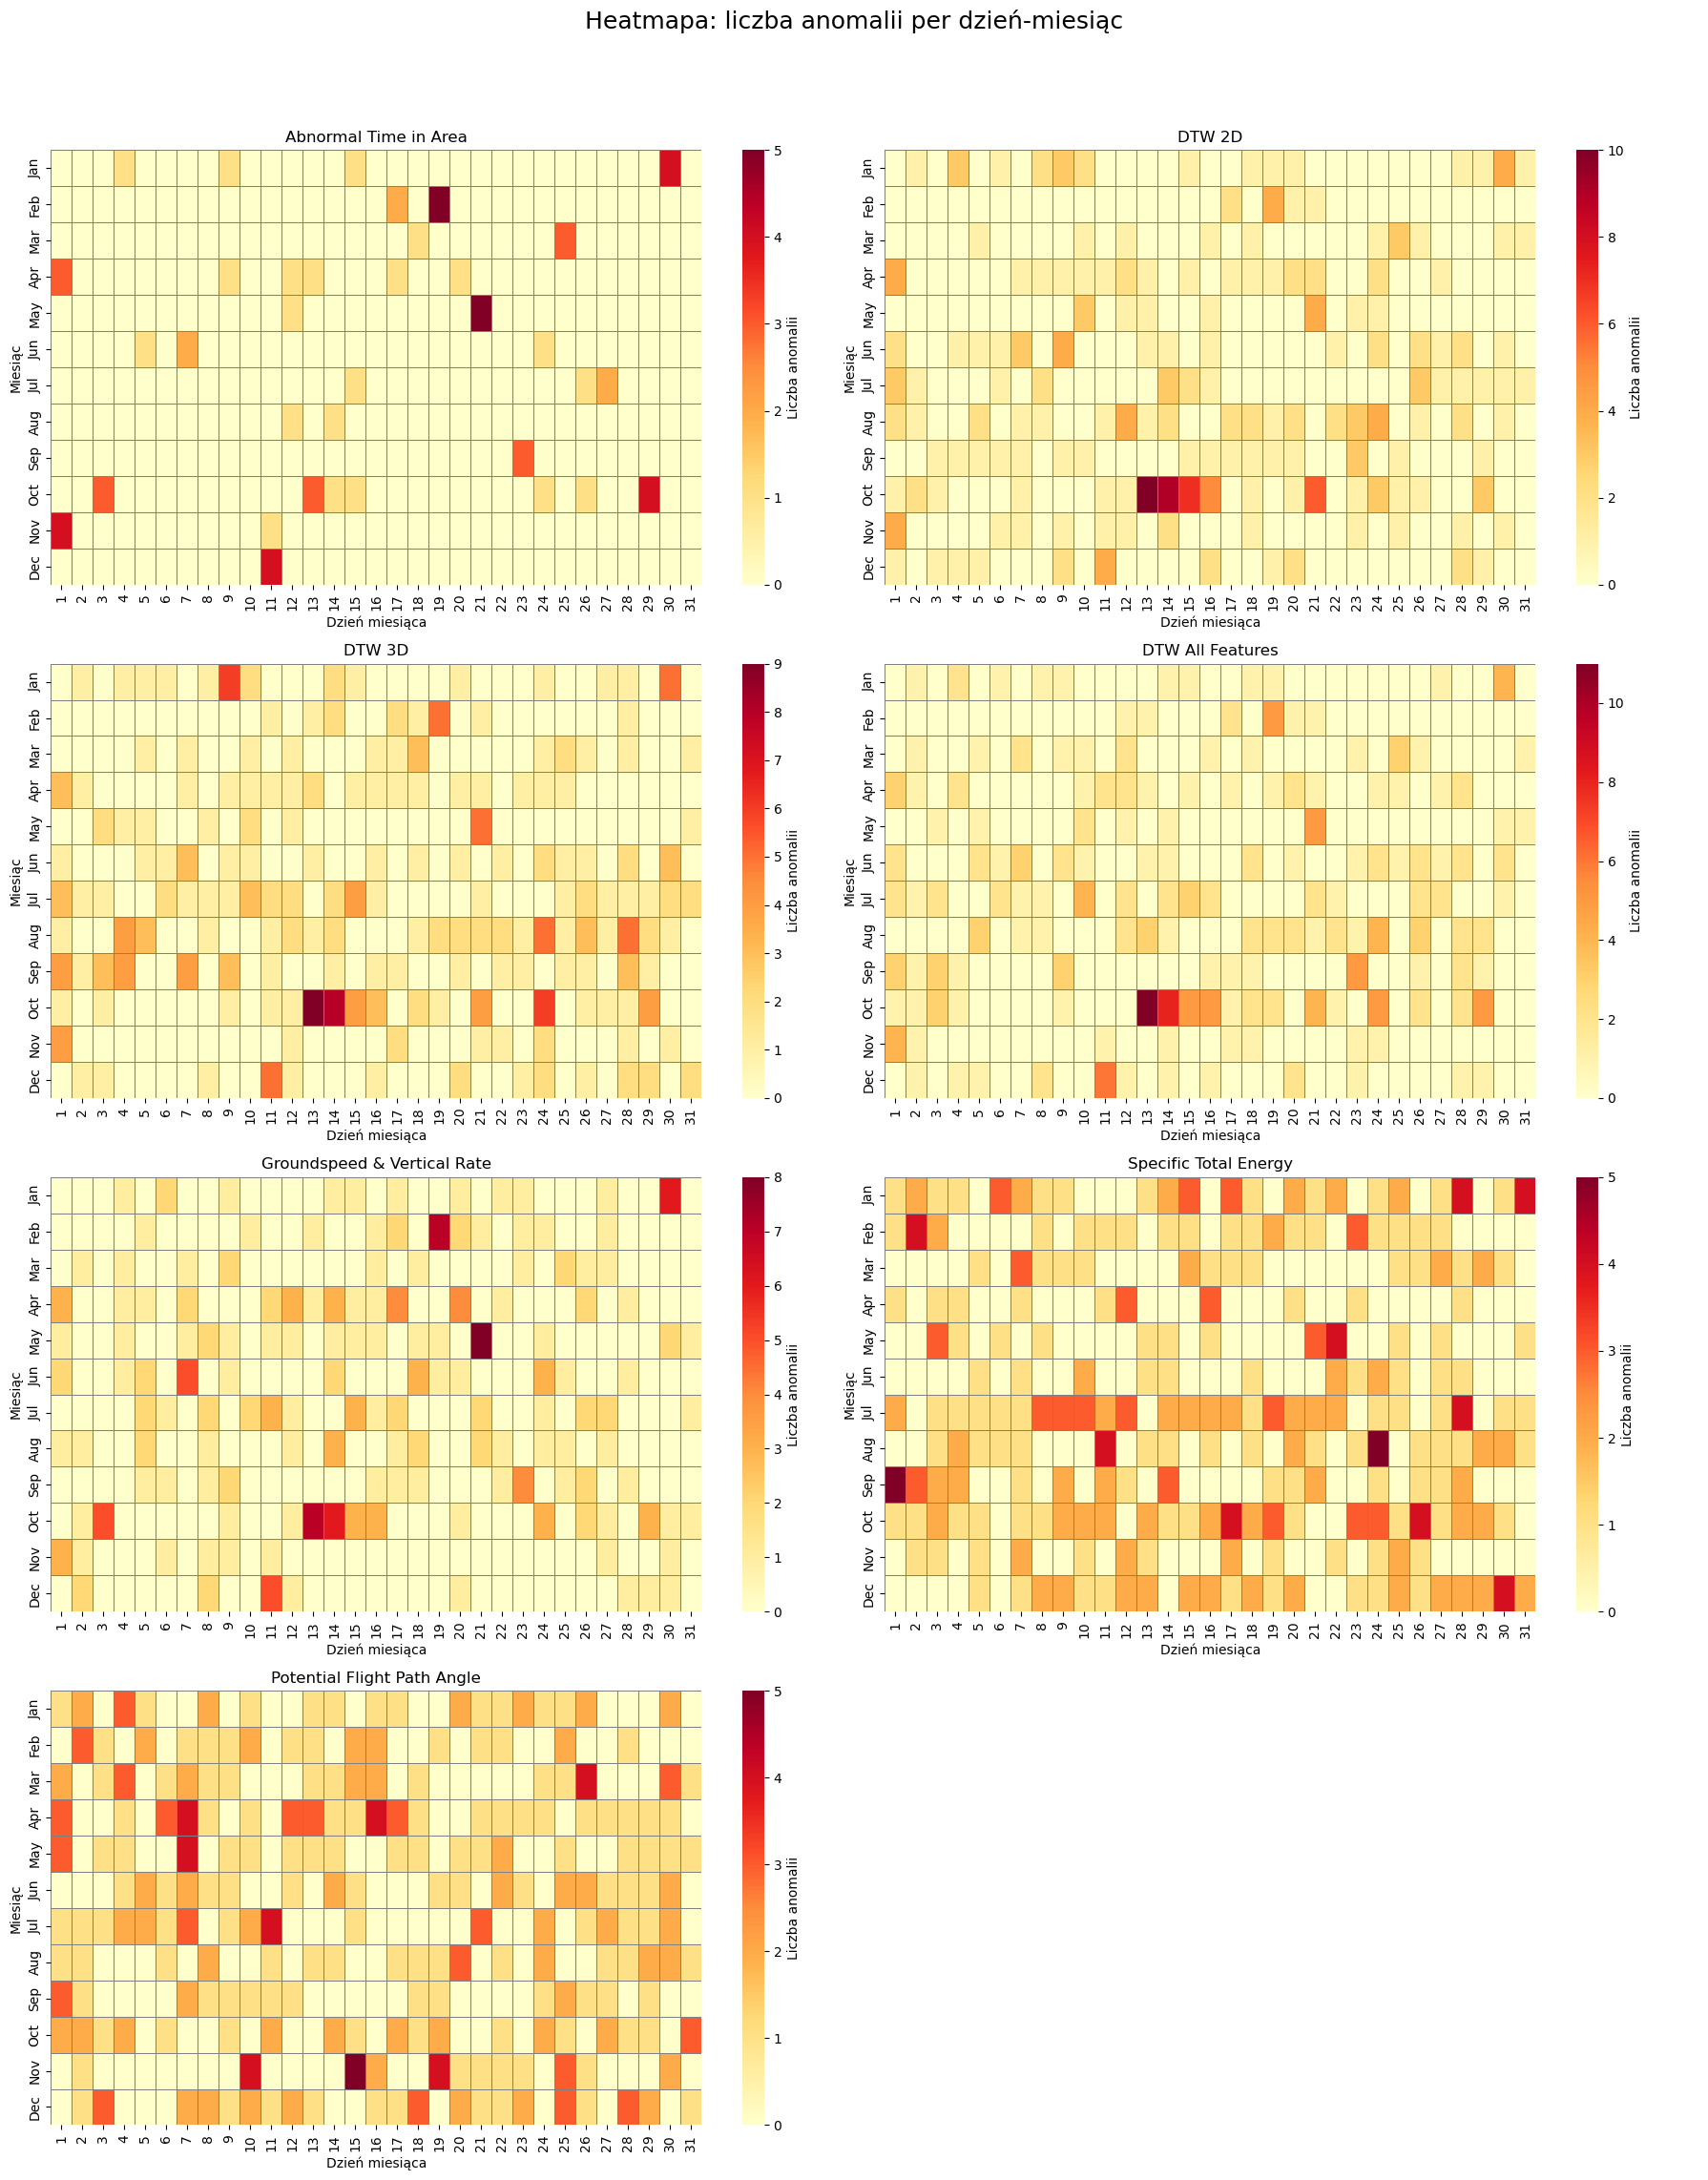

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import calendar

methods = [
    ("Abnormal Time in Area", abnormal_time_in_area_traffic),
    ("DTW 2D", dtw_2d_traffic),
    ("DTW 3D", dtw_3d_traffic),
    ("DTW All Features", dtw_all_traffic),
    ("Groundspeed & Vertical Rate", dtw_groundspeed_vertical_traffic),
    ("Specific Total Energy", ste_traffic),
    ("Potential Flight Path Angle", pfpa_traffic)
    ]

def count_per_callsign(traffic):
    d = {}
    for flight in traffic:
        c = flight.callsign
        d[c] = d.get(c, 0) + 1
    return d

def count_per_icao24(traffic):
    d = {}
    for flight in traffic:
        c = flight.icao24
        d[c] = d.get(c, 0) + 1
    return d

def count_per_month(traffic):
    d = {}
    for flight in traffic:
        m = flight.start.month
        d[m] = d.get(m, 0) + 1
    return d

def count_per_month_day(traffic):
    d = {}
    for flight in traffic:
        m = flight.start.month
        day = flight.start.day
        d[(m, day)] = d.get((m, day), 0) + 1
    return d

n_methods = len(methods)
nrows, ncols = 4, 2

# 1. Liczba anomalii per callsign (top 10)
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 24))
fig.suptitle('Liczba anomalii per callsign (top 10)', fontsize=18)
for idx, (name, traffic) in enumerate(methods):
    row, col = divmod(idx, ncols)
    d = count_per_callsign(traffic)
    top = sorted(d.items(), key=lambda x: x[1], reverse=True)[:10]
    if top:
        x, y = zip(*top)
    else:
        x, y = [], []
    axs[row, col].bar(x, y)
    axs[row, col].set_title(name)
    axs[row, col].set_xticklabels(x, rotation=90)
    axs[row, col].set_ylabel('Liczba anomalii')
# Puste pole jeśli mniej metod niż osi
for idx in range(n_methods, nrows*ncols):
    row, col = divmod(idx, ncols)
    axs[row, col].axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2. Liczba anomalii per ICAO24 (top 10)
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 24))
fig.suptitle('Liczba anomalii per ICAO24 (top 10)', fontsize=18)
for idx, (name, traffic) in enumerate(methods):
    row, col = divmod(idx, ncols)
    d = count_per_icao24(traffic)
    top = sorted(d.items(), key=lambda x: x[1], reverse=True)[:10]
    if top:
        x, y = zip(*top)
    else:
        x, y = [], []
    axs[row, col].bar(x, y)
    axs[row, col].set_title(name)
    axs[row, col].set_xticklabels(x, rotation=90)
    axs[row, col].set_ylabel('Liczba anomalii')
for idx in range(n_methods, nrows*ncols):
    row, col = divmod(idx, ncols)
    axs[row, col].axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 3. Liczba anomalii per miesiąc
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 24))
fig.suptitle('Liczba anomalii per miesiąc', fontsize=18)
months = [calendar.month_abbr[m] for m in range(1,13)]
for idx, (name, traffic) in enumerate(methods):
    row, col = divmod(idx, ncols)
    d = count_per_month(traffic)
    y = [d.get(m, 0) for m in range(1,13)]
    axs[row, col].bar(months, y)
    axs[row, col].set_title(name)
    axs[row, col].set_ylabel('Liczba anomalii')
for idx in range(n_methods, nrows*ncols):
    row, col = divmod(idx, ncols)
    axs[row, col].axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 4. Heatmapa: liczba anomalii per dzień-miesiąc
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 24))
fig.suptitle('Heatmapa: liczba anomalii per dzień-miesiąc', fontsize=18)
max_days = 31
for idx, (name, traffic) in enumerate(methods):
    row, col = divmod(idx, ncols)
    d = count_per_month_day(traffic)
    data = np.zeros((12, max_days), dtype=int)
    for (m, day), count in d.items():
        data[m-1, day-1] = count
    df_grid = pd.DataFrame(data, index=[calendar.month_abbr[m] for m in range(1,13)], columns=range(1, max_days+1))
    sns.heatmap(df_grid, cmap="YlOrRd", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Liczba anomalii'}, ax=axs[row, col])
    axs[row, col].set_title(name)
    axs[row, col].set_xlabel('Dzień miesiąca')
    axs[row, col].set_ylabel('Miesiąc')
for idx in range(n_methods, nrows*ncols):
    row, col = divmod(idx, ncols)
    axs[row, col].axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Impact of another factors on the anomalies

## Time in area and DTW

### Weather
We see that the anomalies for time in area, 2D trajectories, 3D trajectories, and all features and groundspeed & vertical rate time-series are concentrated in the same period of time 13-16 October 2022. So we analyze the weather conditions during this period.

In [3]:
df = pd.read_csv("../weather/12375-2022.csv")

In [28]:
def plot_wind_grid(df, month, days):
    coco_labels = [
        "Clear", "Fair", "Cloudy", "Overcast", "Fog", "Freezing Fog", "Light Rain", "Rain", "Heavy Rain",
        "Freezing Rain", "Heavy Freezing Rain", "Sleet", "Heavy Sleet", "Light Snowfall", "Snowfall", "Heavy Snowfall",
        "Rain Shower", "Heavy Rain Shower", "Sleet Shower", "Heavy Sleet Shower", "Snow Shower", "Heavy Snow Shower",
        "Lightning", "Hail", "Thunderstorm", "Heavy Thunderstorm", "Storm"
    ]
    n_days = len(days)
    ncols = 2
    nrows = (n_days + ncols - 1) // ncols

    # Get max wind speed/gust for scaling
    max_wspd = df['wspd'].max(skipna=True)
    max_wpgt = df['wpgt'].max(skipna=True)
    max_wind = max(max_wspd, max_wpgt)

    fig, axs = plt.subplots(nrows * 2, ncols, figsize=(12 * ncols, 10 * nrows), sharey='row')
    axs = axs.reshape(nrows, 2, ncols)  # shape: (nrows, 2, ncols)
    for i, day in enumerate(days):
        row, col = divmod(i, ncols)
        df_day = df[(df['month'] == month) & (df['day'] == day)]
        # Wind plot
        ax1 = axs[row, 0, col]
        ax1.plot(df_day['hour'], df_day['wspd'], marker='o', color='b', label='Wind Speed (m/s)')
        ax1.plot(df_day['hour'], df_day['wpgt'], marker='s', color='r', label='Wind Gust (m/s)')
        ax1.set_xlabel('Hour')
        ax1.set_ylabel('Wind Speed / Gust (m/s)', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        ax1.set_xticks(range(0, 24))
        ax1.set_ylim(0, max(1, max_wind * 1.05))
        ax1.grid(True)
        ax2 = ax1.twinx()
        ax2.plot(df_day['hour'], df_day['wdir'], marker='x', color='g', label='Wind Direction (°)')
        ax2.set_ylabel('Wind Direction (°)', color='g')
        ax2.tick_params(axis='y', labelcolor='g')
        ax2.set_ylim(0, 360)
        ax1.set_title(f'{calendar.month_abbr[month]} {day}')
        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        # Coco plot
        ax_coco = axs[row, 1, col]
        ax_coco.plot(df_day['hour'], df_day['coco'], marker='o', linestyle='-', color='purple')
        ax_coco.set_xlabel('Hour')
        ax_coco.set_ylabel('Weather Code (coco)')
        ax_coco.set_title(f'Weather Code on {calendar.month_abbr[month]} {day}')
        ax_coco.set_xticks(range(0, 24))
        ax_coco.set_yticks(range(1, 28))
        ax_coco.set_yticklabels(coco_labels)
        ax_coco.grid(True, axis='y', linestyle='--', alpha=0.5)
    # Hide unused subplots
    for j in range(i + 1, nrows * ncols):
        row, col = divmod(j, ncols)
        axs[row, 0, col].axis('off')
        axs[row, 1, col].axis('off')
    plt.suptitle(f'Wind & Weather Code by Hour for {calendar.month_abbr[month]} Days: {days}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

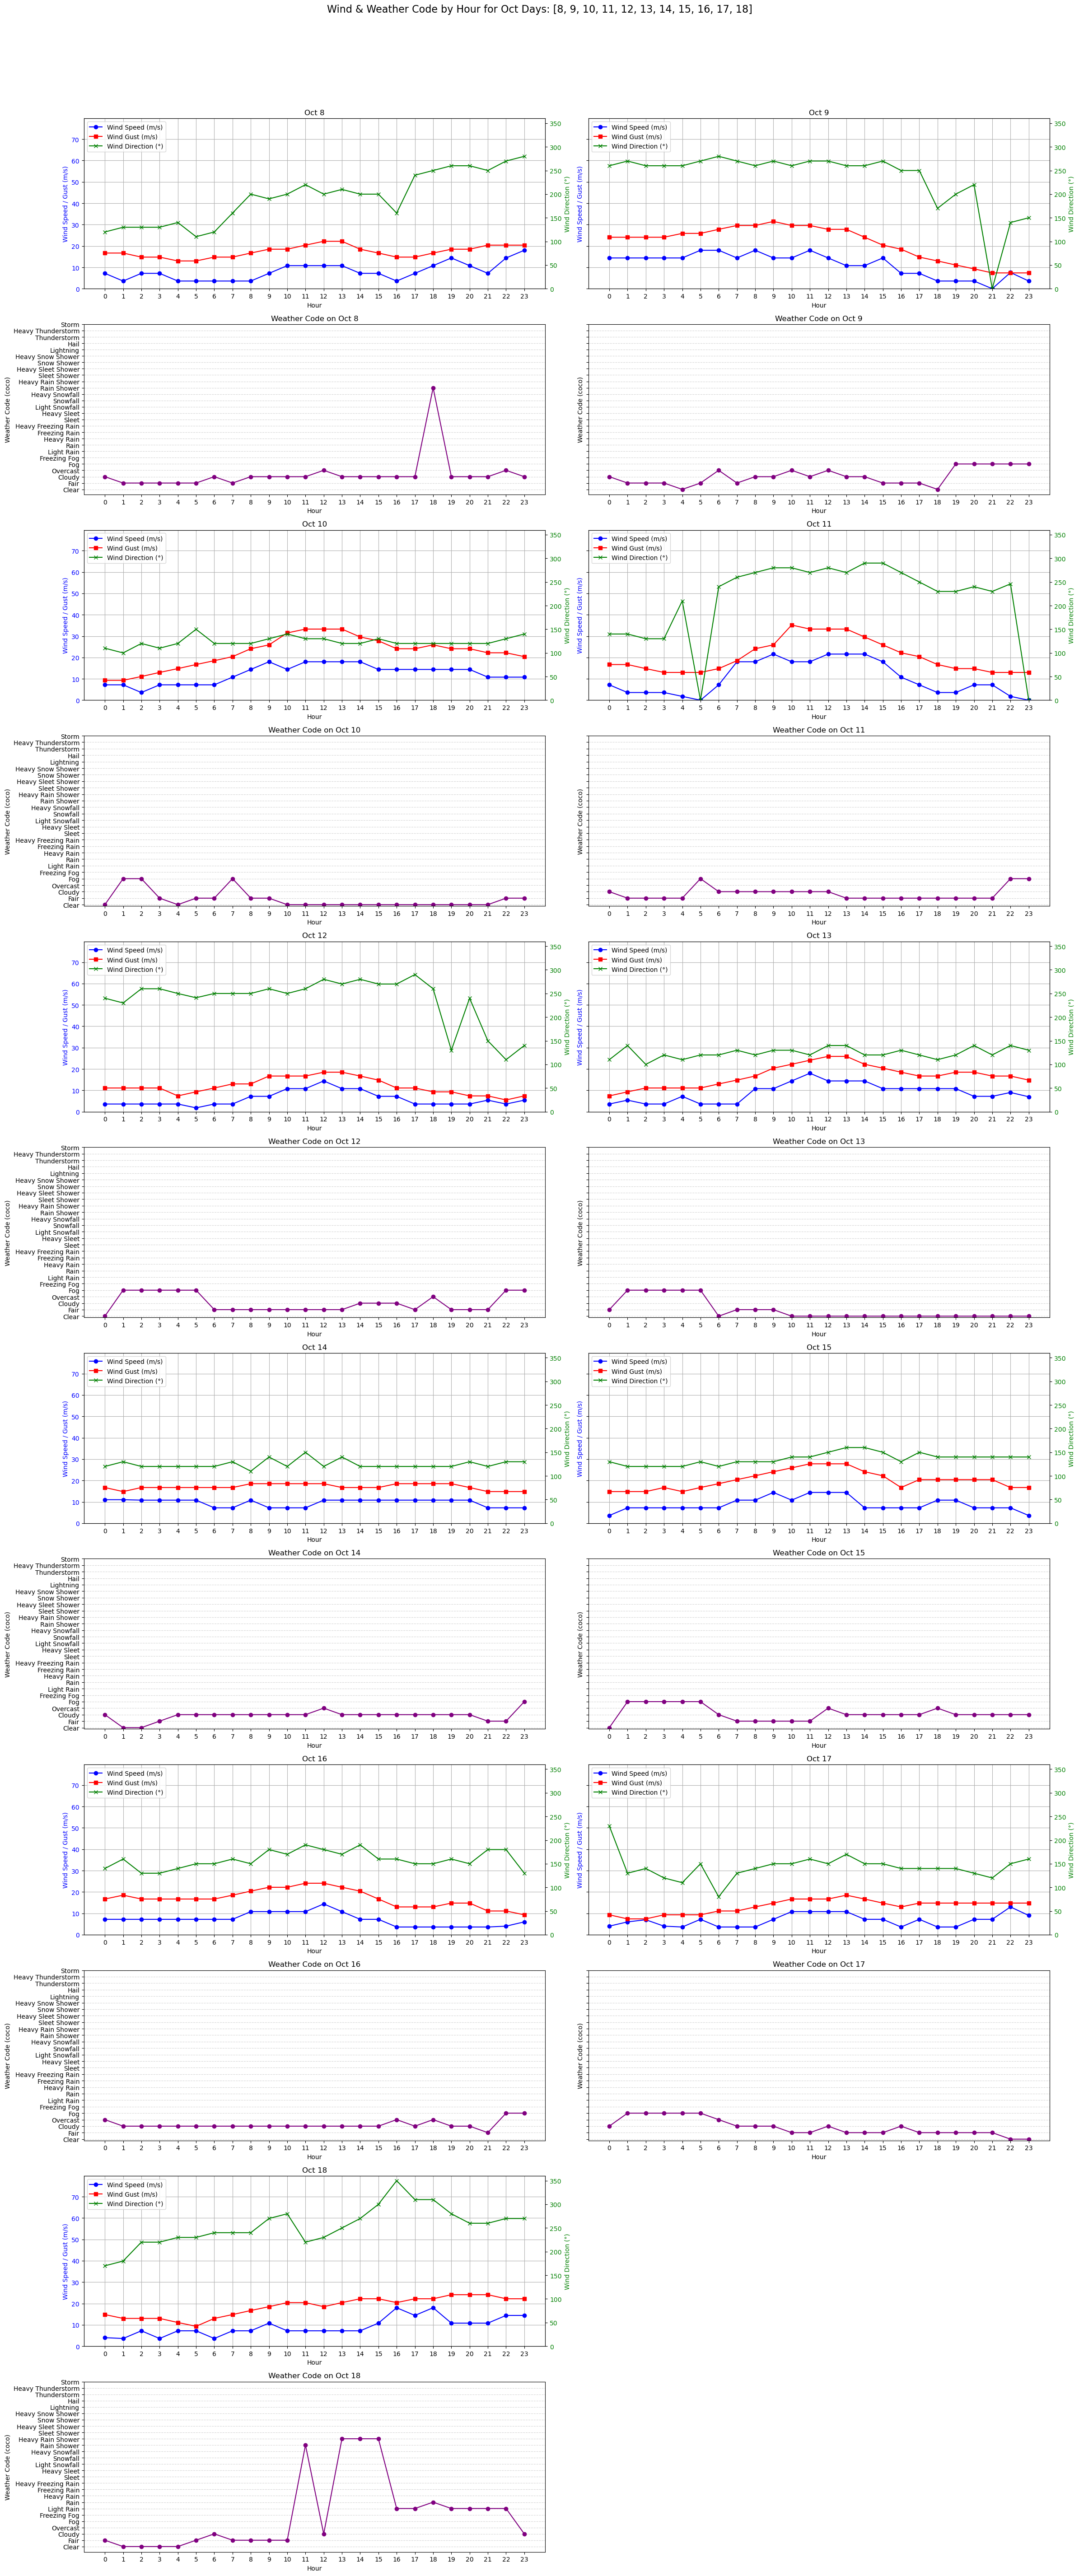

In [29]:
plot_wind_grid(df, 10, list(range(8, 19)))

We see that 13th October 2022 was not a day that is different from others. Therefore, we analyze abnormal trajectories from this day in more detail.

In [20]:
dtw_2d_traffic_1310 = dtw_2d_traffic.query("timestamp.dt.month == 10 and timestamp.dt.day == 13")

In [22]:
dtw_2d_traffic_1310

icao24 callsign  count
0  48ad01   LOT318   1485
1  48ae83   LOT9PU   1312
2  461f31  FIN1143   1249
3  48ad02   LOT48F   1144
4  48932b   LOT3VT   1083
5  489324   LOT7YC   1064
6  489325  LOT3904    890
7  48ad02   LOT484    739
8  48adad   LOT336    716
9  484130   KLM85R    678

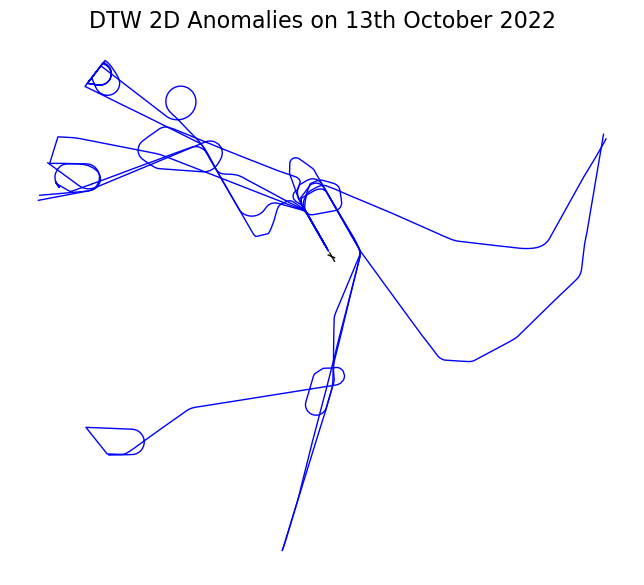

In [24]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_2180()))
    
    airports["EPWA"].plot(ax=ax, footprint=False, runways=dict(linewidth=1))
    for flight in dtw_2d_traffic_1310:
        flight.plot(ax=ax, color="blue", linewidth=1, label=flight.callsign if flight.callsign else "Unknown Callsign")
    ax.set_title("DTW 2D Anomalies on 13th October 2022")
    
    plt.show()

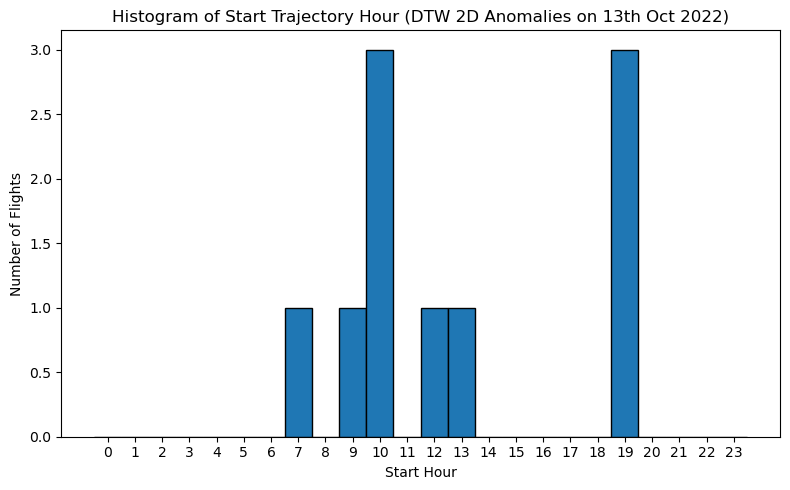

In [25]:
start_hours = [flight.start.hour for flight in dtw_2d_traffic_1310]
plt.figure(figsize=(8, 5))
plt.hist(start_hours, bins=range(0, 25), edgecolor='black', align='left')
plt.xlabel('Start Hour')
plt.ylabel('Number of Flights')
plt.title('Histogram of Start Trajectory Hour (DTW 2D Anomalies on 13th Oct 2022)')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

/tmp/ipykernel_1020/1117487623.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


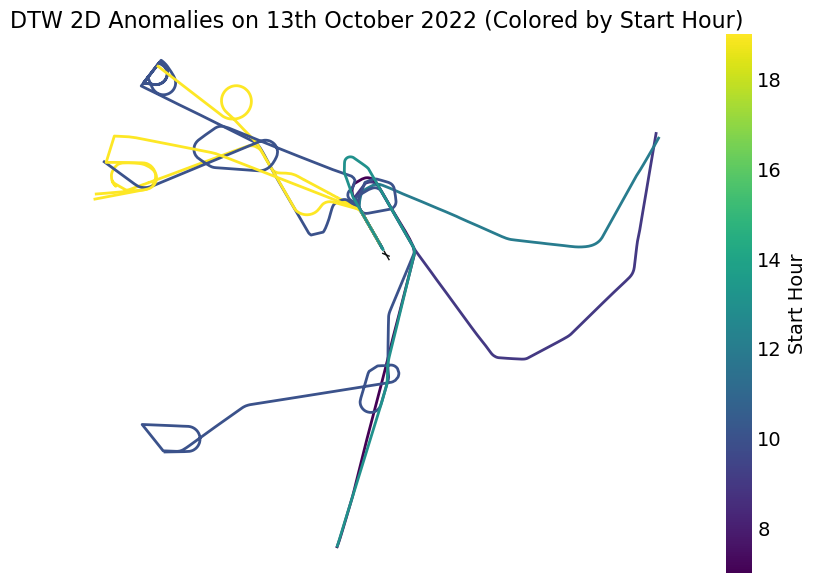

In [26]:
import matplotlib.cm as cm

with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_2180()))
    
    airports["EPWA"].plot(ax=ax, footprint=False, runways=dict(linewidth=1))
    hours = [flight.start.hour for flight in dtw_2d_traffic_1310]
    norm = plt.Normalize(min(hours), max(hours))
    cmap = cm.get_cmap("viridis")
    for flight, hour in zip(dtw_2d_traffic_1310, hours):
        color = cmap(norm(hour))
        flight.plot(ax=ax, color=color, linewidth=2)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Start Hour')
    ax.set_title("DTW 2D Anomalies on 13th October 2022 (Colored by Start Hour)")
    plt.show()

Abnormal trajectories are cumulated at 11:00-12:00 UTC and 18:00-19:00 UTC. Therefore, we will plot the traffic load for this day.

### Traffic load for 13th October 2022

In [32]:
date = pd.Timestamp("2022-10-13")
traffic_arrival = opensky.history(
    start=date, 
    arrival_airport="EPWA", 
    bounds=eurofirs["EPWW"].bounds
)
traffic_arrival = traffic_arrival.assign(
    quarter=lambda df: df.timestamp.dt.quarter,
    month=lambda df: df.timestamp.dt.month,
    day=lambda df: df.timestamp.dt.day,
    hour=lambda df: df.timestamp.dt.hour,
    weekday=lambda df: df.timestamp.dt.weekday,
)

In [33]:
traffic_departure = opensky.history(
    start=date,
    departure_airport="EPWA",
    bounds=eurofirs["EPWW"].bounds
)
traffic_departure = traffic_departure.assign(
    quarter=lambda df: df.timestamp.dt.quarter,
    month=lambda df: df.timestamp.dt.month,
    day=lambda df: df.timestamp.dt.day,
    hour=lambda df: df.timestamp.dt.hour,
    weekday=lambda df: df.timestamp.dt.weekday,
)

RUNNING: : 66.0% [00:13, 4.86%/s]
DOWNLOAD: 532klines [01:35, 5.55klines/s]


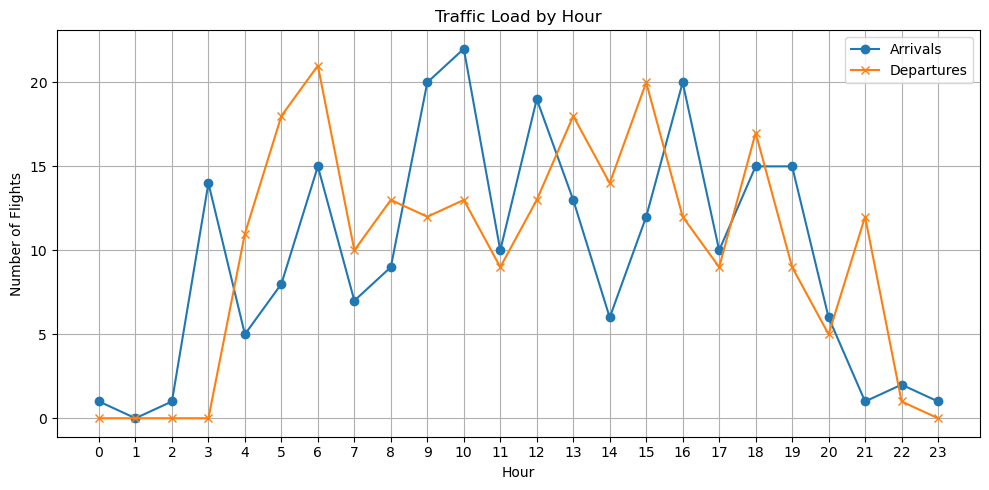

In [34]:
arrival_hours = [flight.data.iloc[0]['hour'] for flight in traffic_arrival]
departure_hours = [flight.data.iloc[0]['hour'] for flight in traffic_departure]

# Count flights per hour
arrival_counts = pd.Series(arrival_hours).value_counts().sort_index()
departure_counts = pd.Series(departure_hours).value_counts().sort_index()

# Ensure all hours are present
hours = range(0, 24)
arrival_counts = arrival_counts.reindex(hours, fill_value=0)
departure_counts = departure_counts.reindex(hours, fill_value=0)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(hours, arrival_counts, marker='o', label='Arrivals')
plt.plot(hours, departure_counts, marker='x', label='Departures')
plt.xlabel('Hour')
plt.ylabel('Number of Flights')
plt.title('Traffic Load by Hour')
plt.xticks(hours)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Between 09:00-11:00 UTC is peak of arrivals, but 18:00-19:00 can be cause by the fact that the airport is loaded by the high number of arrivals and departures during previous hours. I will also analyze LIVE traffic on these hours.

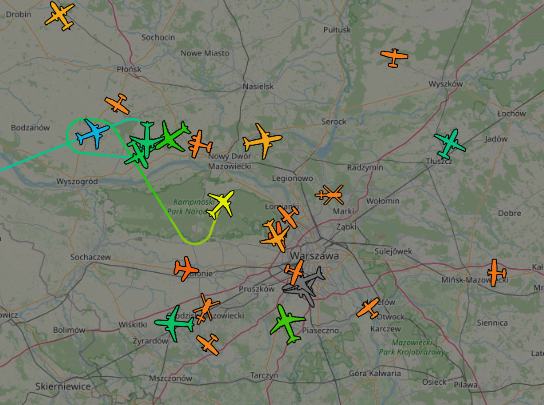

In [36]:
flights_with_landing = [
    (flight.callsign, flight.stop) for flight in dtw_2d_traffic_1310
]
flights_with_landing.sort(key=lambda x: x[1])

for callsign, landing_time in flights_with_landing:
    print(f"{callsign}: {landing_time.hour:02d}:{landing_time.minute:02d}")

LOT3904: 07:40
FIN1143: 10:16
LOT48F: 10:49
LOT3VT: 11:26
LOT318: 11:29
LOT7YC: 12:53
LOT9PU: 13:54
LOT484: 19:32
KLM85R: 20:07
LOT336: 20:20


### FIN1143

In [37]:
FIN1143 = dtw_2d_traffic_1310["FIN1143"]

In [39]:
FIN1143.map_leaflet()

Map(center=[52.08757328604376, 21.60096204895489], controls=(ZoomControl(options=['position', 'zoom_in_text', …

Aircraft flew to EPWA longer route than expected. Maybe that was caused by high traffic load, what is visible on the image below:

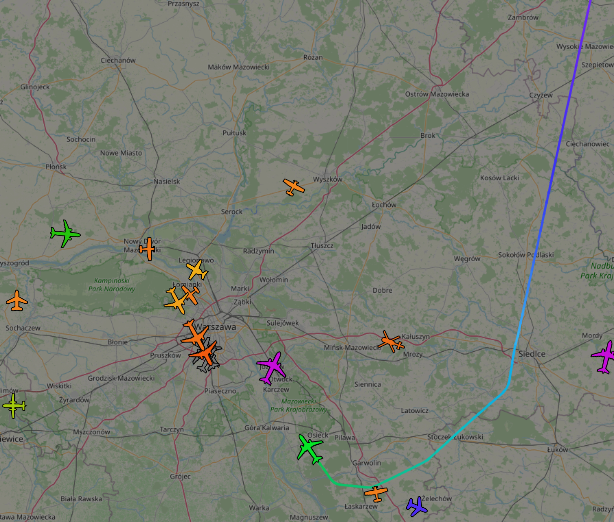

We will plot the trajectories of FIN1143 that landed at runway 15 to compare it with this trajectory.

In [46]:
trajectories_folder = '../datasetsV2/dataset_specific_callsigns/trajectories'

In [47]:
def extract_flights_per_runway(callsign=None):
    """
    Extracts flights for each runway from the specified directory. Optionally filters by callsign.
    Returns a dictionary mapping runway numbers to Traffic objects.
    """
    runway_traffic = {}
    all_flights = []
    for subfolder in os.listdir(trajectories_folder):
        subfolder_path = os.path.join(trajectories_folder, subfolder)
        if os.path.isdir(subfolder_path):
            flights = []
            for filename in os.listdir(subfolder_path):
                if callsign and callsign in filename or not callsign:
                    file_path = os.path.join(subfolder_path, filename)
                    flights.append(Flight.from_file(file_path))
            if flights:
                runway_number = ''.join(filter(str.isdigit, subfolder))
                runway_traffic[int(runway_number)] = Traffic.from_flights(flights)
                all_flights.extend(flights)
    return runway_traffic, Traffic.from_flights(all_flights)

In [48]:
traffic_per_runway, traffic = extract_flights_per_runway(callsign="FIN1143")

In [49]:
traffic

icao24 callsign  count
0  461e18  FIN1143  32326
1  461e1b  FIN1143  31168
2  461e1c  FIN1143  30435
3  461e21  FIN1143  28847
4  461e17  FIN1143  28703
5  461e14  FIN1143  25908
6  461e1f  FIN1143  24798
7  461e16  FIN1143  20147
8  461e15  FIN1143  17913
9  461e1d  FIN1143  17753

In [57]:
traffic_per_runway[15]

icao24 callsign  count
0  461e1b  FIN1143   1529
1  461e14  FIN1143   1495
2  461f31  FIN1143   1249

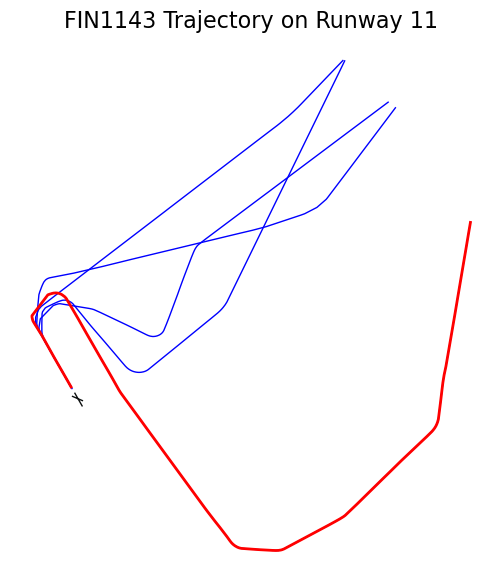

In [58]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_2180()))
    
    airports["EPWA"].plot(ax=ax, footprint=False, runways=dict(linewidth=1))
    for flight in traffic_per_runway[15]:
        flight.plot(ax=ax, color="blue", linewidth=1, label=flight.callsign if flight.callsign else "Unknown Callsign")
    FIN1143.plot(ax=ax, color="red", linewidth=2, label="FIN1143")
    ax.set_title("FIN1143 Trajectory on Runway 11")
    
    plt.show()

/tmp/ipykernel_1020/2606500986.py:11: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



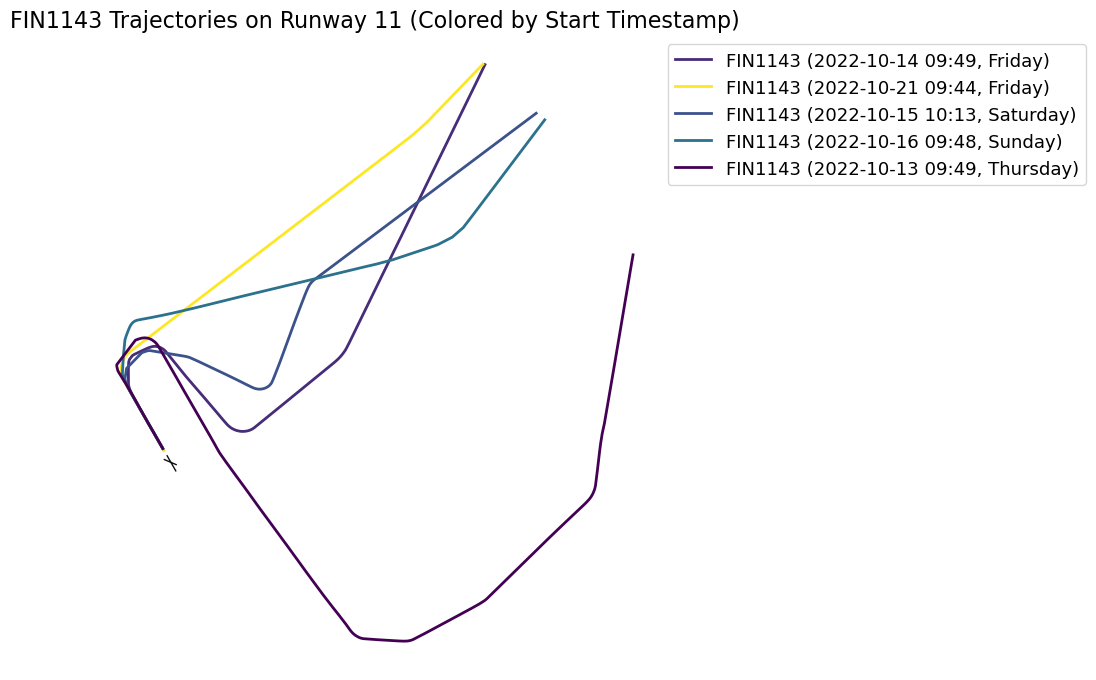

In [62]:
import matplotlib.cm as cm
import matplotlib.lines as mlines

with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_2180()))
    airports["EPWA"].plot(ax=ax, footprint=False, runways=dict(linewidth=1))
    
    flights = list(traffic_per_runway[15])
    start_times = [flight.start.timestamp() for flight in flights]
    norm = plt.Normalize(min(start_times), max(start_times))
    cmap = cm.get_cmap("viridis")
    
    for flight, t in zip(flights, start_times):
        color = cmap(norm(t))
        flight.plot(ax=ax, color=color, linewidth=2)
    
    # Add legend with callsign, start time, and weekday
    handles = []
    for flight in flights:
        weekday = flight.start.strftime("%A")
        label = f"{flight.callsign} ({flight.start:%Y-%m-%d %H:%M}, {weekday})"
        color = cmap(norm(flight.start.timestamp()))
        handles.append(mlines.Line2D([], [], color=color, linewidth=2, label=label))
    ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1))
    
    ax.set_title("FIN1143 Trajectories on Runway 11 (Colored by Start Timestamp)")
    plt.tight_layout()
    plt.show()


We see that flight landing on runway 15 are only from October. Maybe this is reason why the number of abnormal trajectories is higher in this period. 

In [63]:
traffic_per_runway, traffic = extract_flights_per_runway()

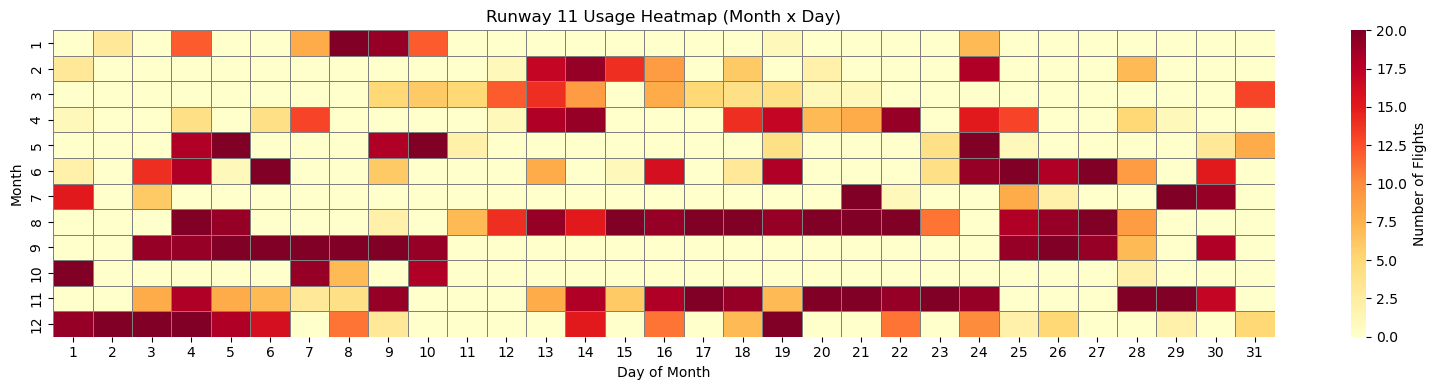

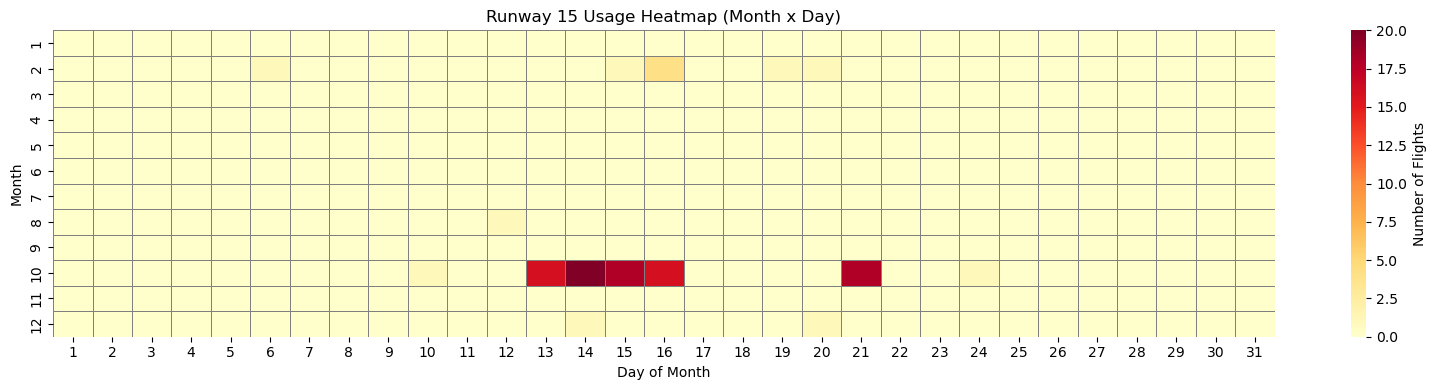

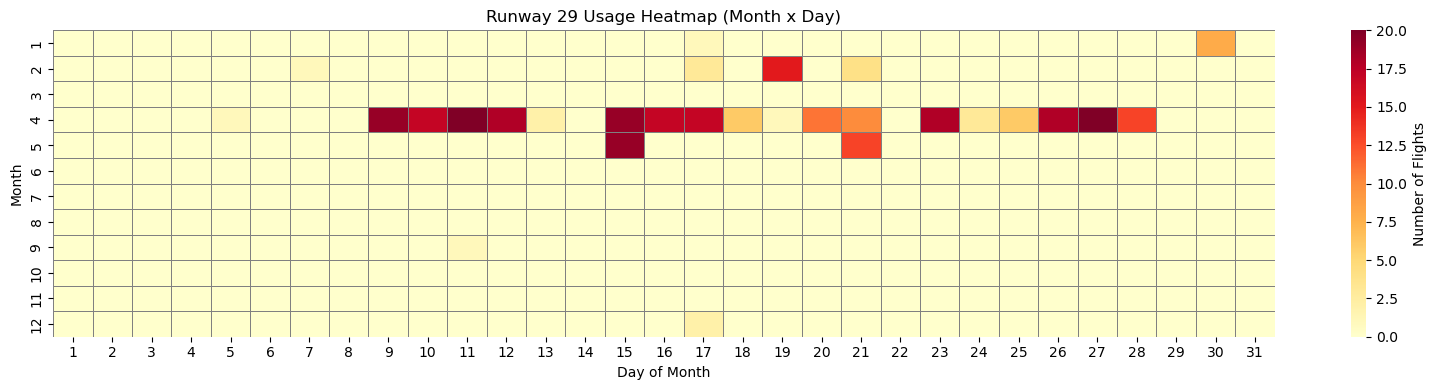

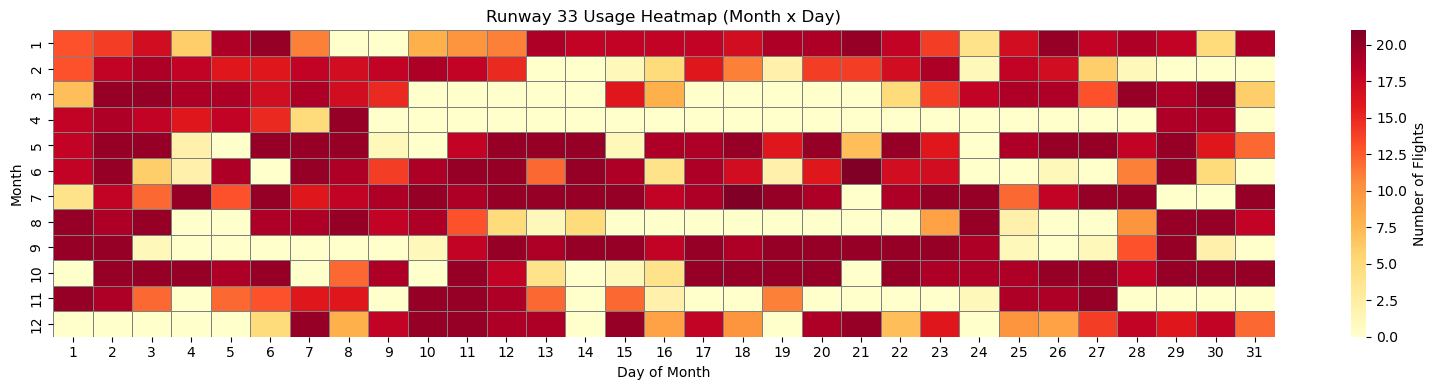

In [65]:
import seaborn as sns

for runway in runway_usage.columns:
    plt.figure(figsize=(16, 4))
    data = runway_usage[runway]
    # Convert to DataFrame for heatmap (reshape to 2D: months x days)
    df_heat = data.copy()
    df_heat.index = pd.to_datetime(df_heat.index)
    heatmap_data = df_heat.groupby([df_heat.index.month, df_heat.index.day]).sum().unstack(fill_value=0)
    sns.heatmap(heatmap_data, cmap="YlOrRd", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Number of Flights'})
    plt.title(f"Runway {runway} Usage Heatmap (Month x Day)")
    plt.xlabel("Day of Month")
    plt.ylabel("Month")
    plt.tight_layout()
    plt.show()


That is the reason, why the abnormal trajectories are concentrated in the period 13-16 October 2022. During the whole year, only at this period, the runway 15 was used for landings at this scale.

## Specific Total Energy
In 24th August 2022, the number of abnormal trajectories in context of STE was higher than in other days. We will analyze this day in more detail. 

In [69]:
ste_2408 = ste_traffic.query("timestamp.dt.month == 8 and timestamp.dt.day == 24")

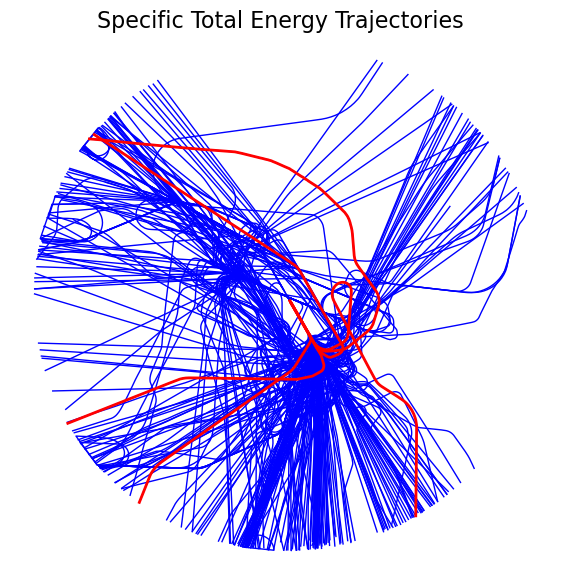

In [ ]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_2180()))
    
    airports["EPWA"].plot(ax=ax, footprint=False, runways=dict(linewidth=1))
    for flight in ste_traffic:
        flight.plot(ax=ax, color="blue", linewidth=1, label=traffic.callsign if traffic.callsign else "Unknown Callsign")
        
    for flight in ste_2408:
        flight.plot(ax=ax, color="red", linewidth=2, label=flight.callsign if flight.callsign else "Unknown Callsign")
        
    ax.set_title("Specific Total Energy Trajectories")
    
    plt.show()

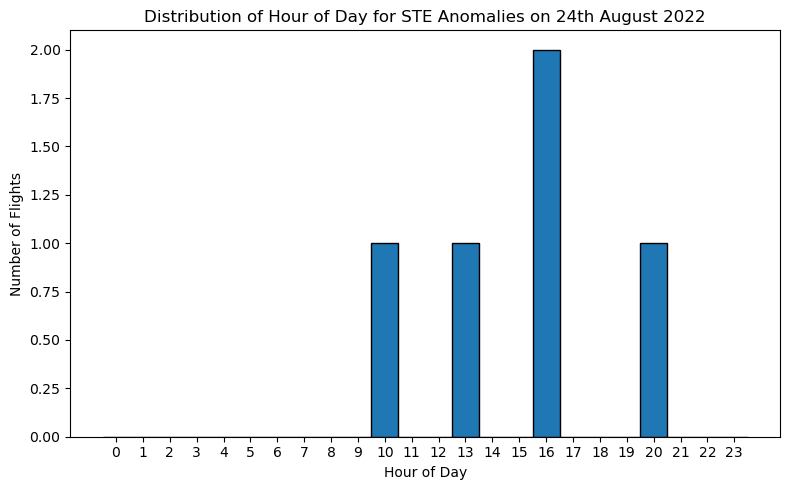

In [71]:
hours = [flight.start.hour for flight in ste_2408]
plt.figure(figsize=(8, 5))
plt.hist(hours, bins=range(0, 25), edgecolor='black', align='left')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Flights')
plt.title('Distribution of Hour of Day for STE Anomalies on 24th August 2022')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

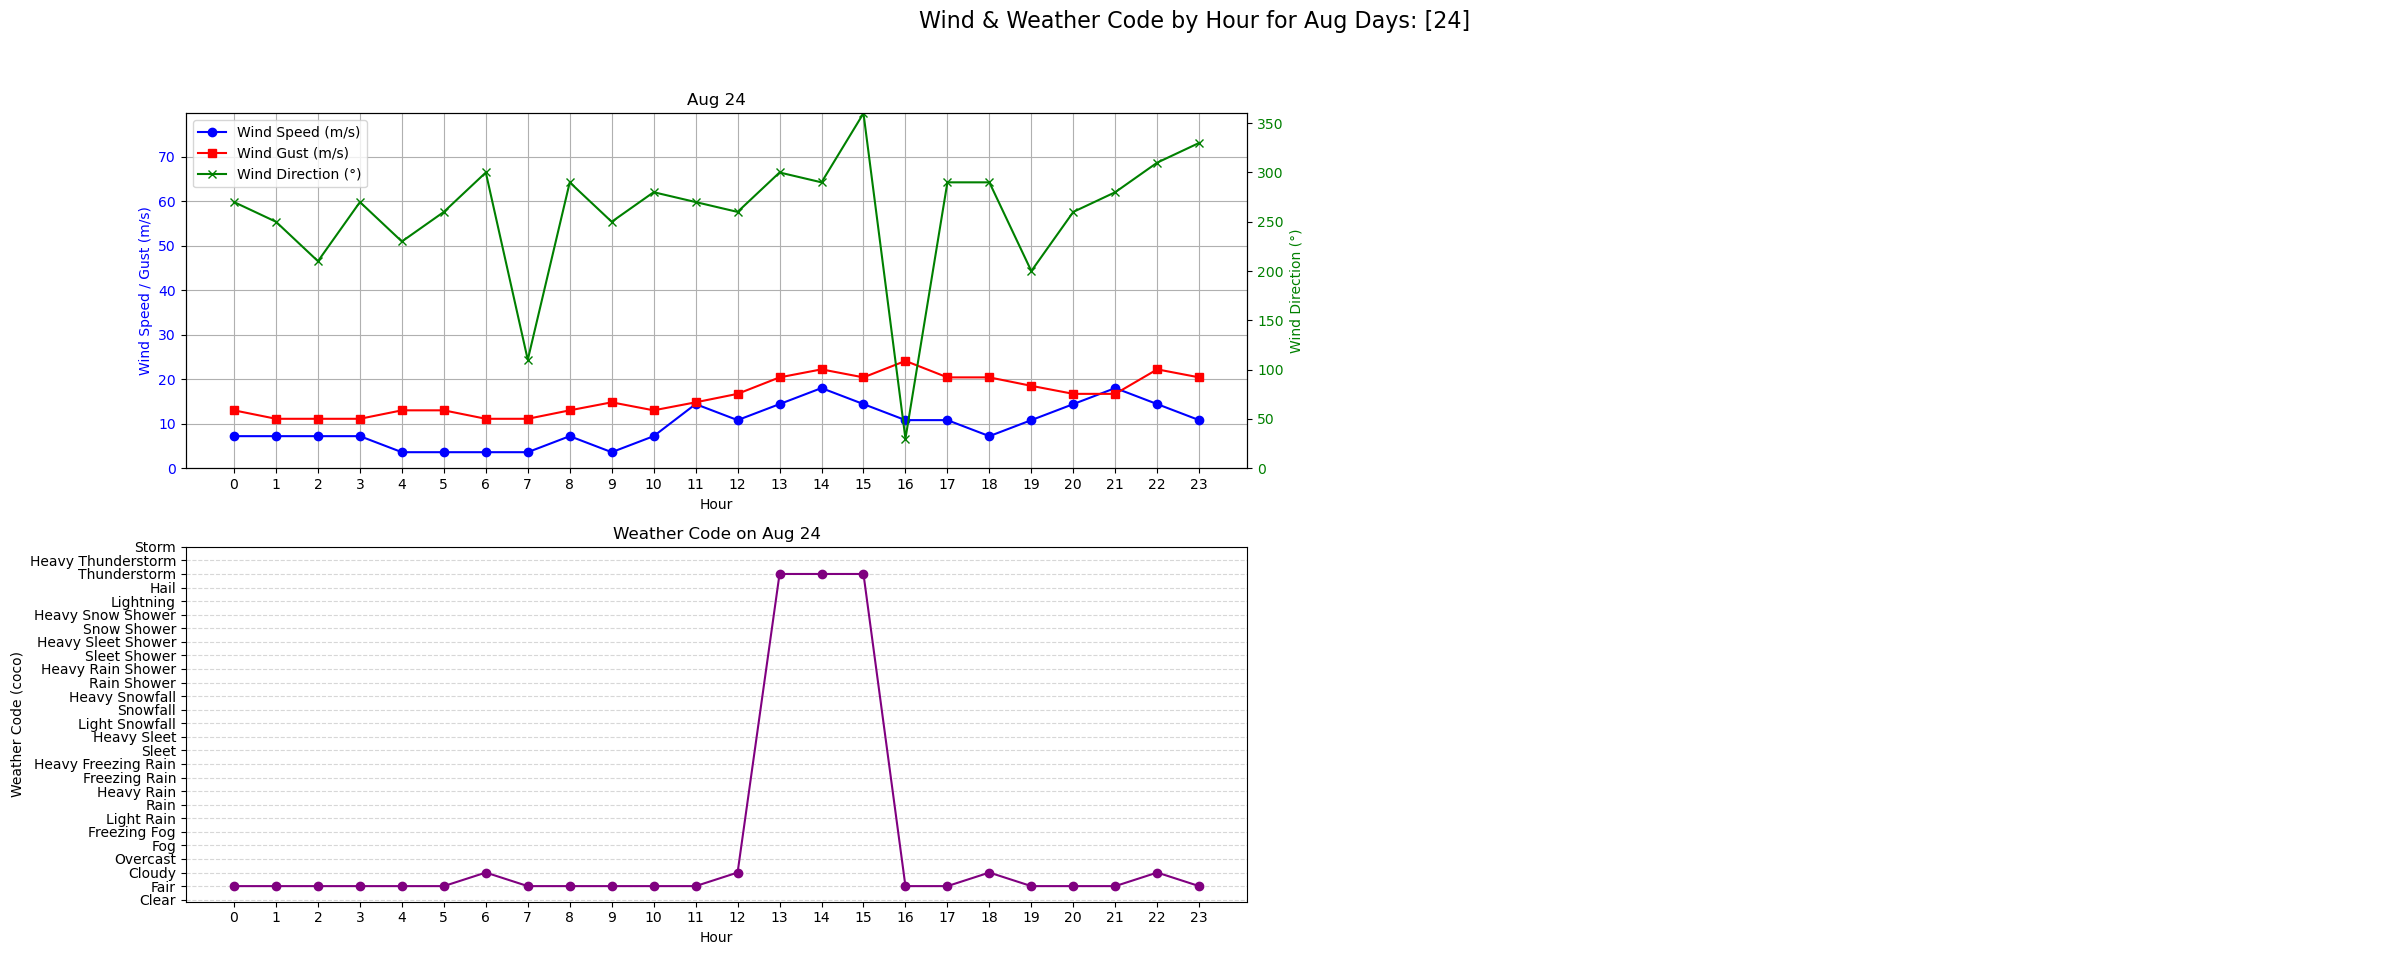

In [73]:
plot_wind_grid(df, 8, [24])

/tmp/ipykernel_1020/1657510437.py:11: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



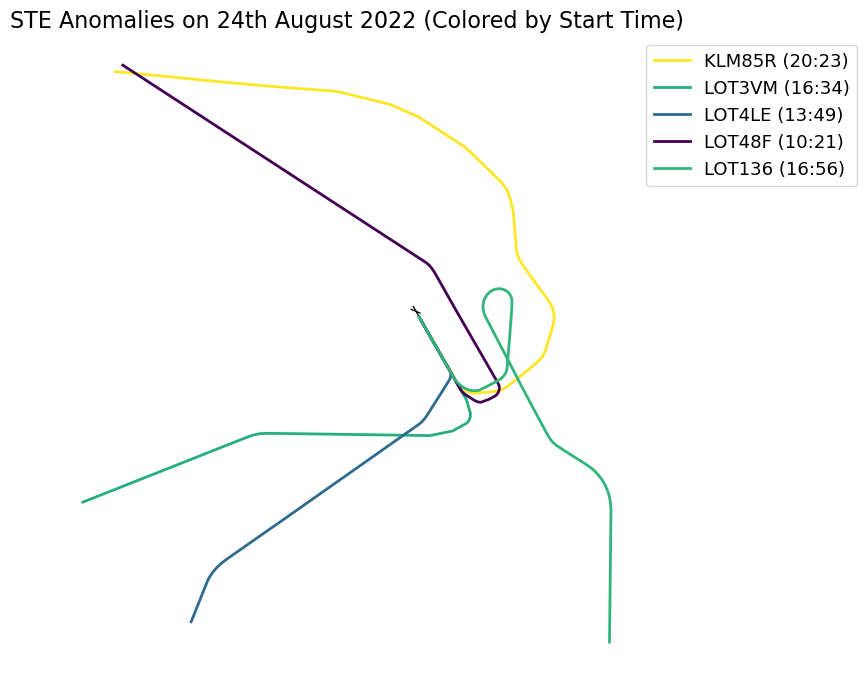

In [76]:
import matplotlib.cm as cm
import matplotlib.lines as mlines

with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_2180()))
    airports["EPWA"].plot(ax=ax, footprint=False, runways=dict(linewidth=1))
    
    flights = list(ste_2408)
    start_times = [flight.start.timestamp() for flight in flights]
    norm = plt.Normalize(min(start_times), max(start_times))
    cmap = cm.get_cmap("viridis")
    
    handles = []
    for flight, t in zip(flights, start_times):
        color = cmap(norm(t))
        flight.plot(ax=ax, color=color, linewidth=2)
        label = f"{flight.callsign} ({flight.start:%H:%M})"
        handles.append(mlines.Line2D([], [], color=color, linewidth=2, label=label))
    
    ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1))
    
    ax.set_title("STE Anomalies on 24th August 2022 (Colored by Start Time)")
    plt.tight_layout()
    plt.show()


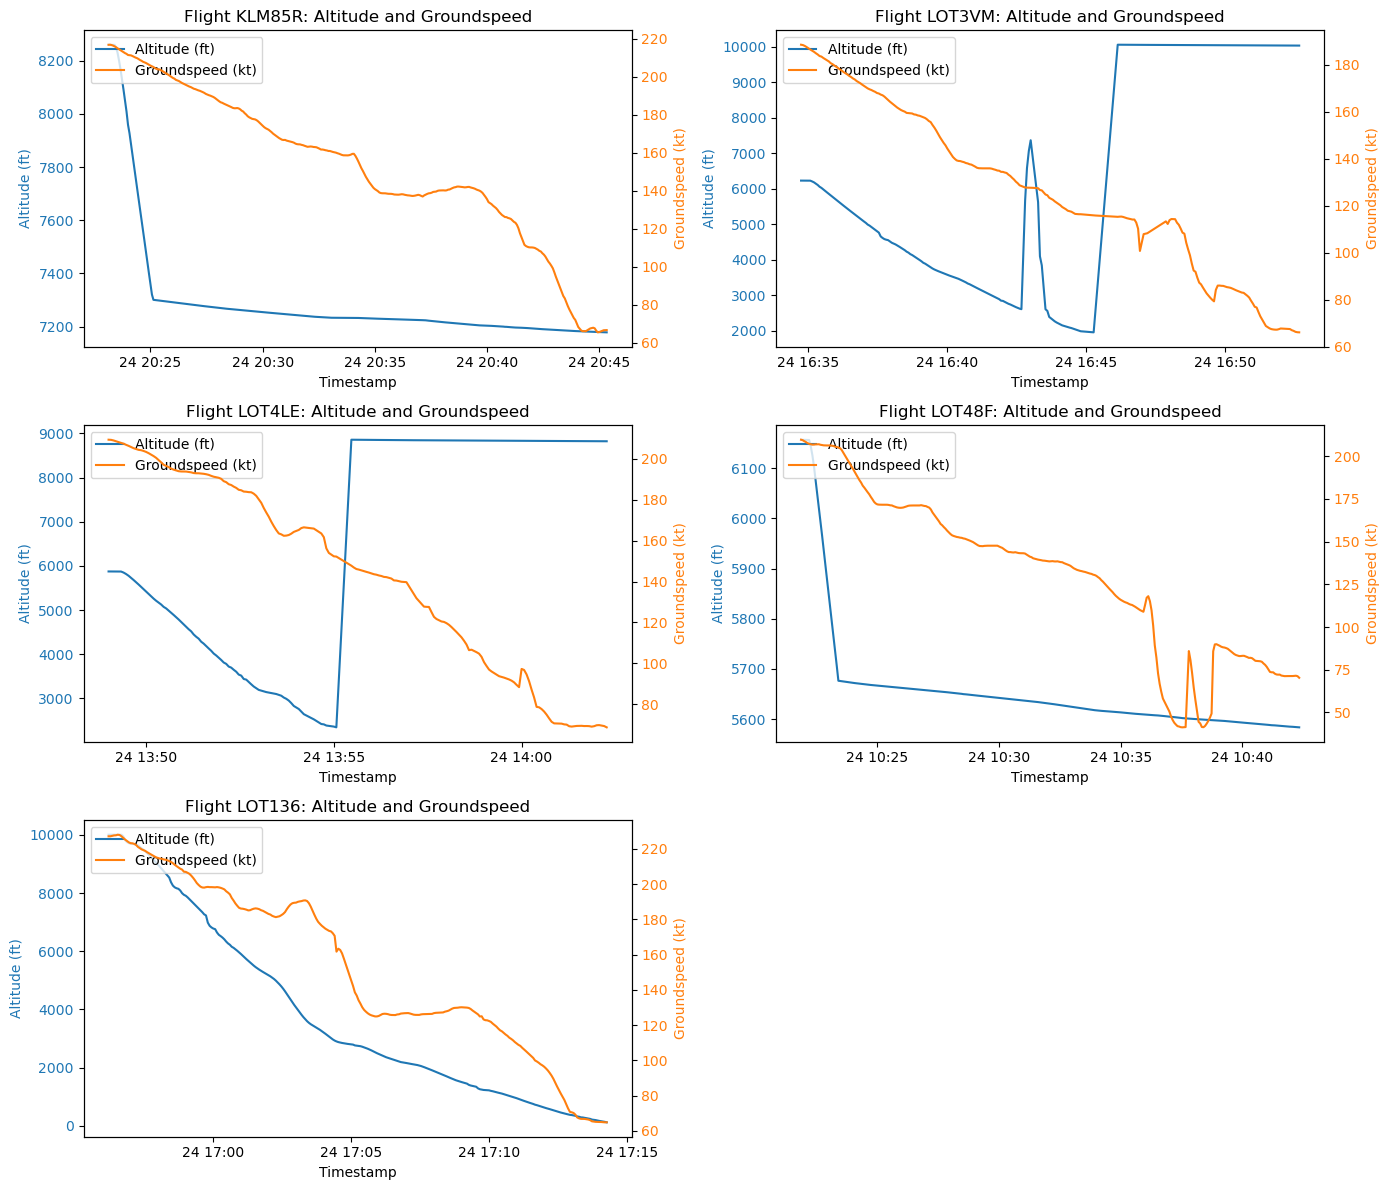

In [78]:
import math

n_flights = len(ste_2408)
ncols = 2
nrows = math.ceil(n_flights / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(14, 4 * nrows), sharex=False)
axs = axs.flatten()

for idx, flight in enumerate(ste_2408):
    data = flight.data
    ax1 = axs[idx]
    ax2 = ax1.twinx()
    ax1.plot(data['timestamp'], data['altitude'], color='tab:blue', label='Altitude (ft)')
    ax2.plot(data['timestamp'], data['groundspeed'], color='tab:orange', label='Groundspeed (kt)')
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Altitude (ft)', color='tab:blue')
    ax2.set_ylabel('Groundspeed (kt)', color='tab:orange')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax1.set_title(f"Flight {flight.callsign}: Altitude and Groundspeed")
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Hide unused subplots if any
for idx in range(len(ste_2408), len(axs)):
    axs[idx].axis('off')

plt.tight_layout()
plt.show()

* LOT3VM and LOT4LE - increase of altitude - error of altitude measurement
* LOT48F and KLM85R - error of altitude measurement
* LOT136 - anything special - there is need to compare with other flights.

### LOT136 STE normal vs abnormal

In [79]:
ste_traffic_lot136 = ste_traffic.query("callsign == 'LOT136'")
ste_traffic_lot136

icao24 callsign  count
0  48ada7   LOT136   1210
1  48adab   LOT136   1158
2  48ada5   LOT136    675
3  48ada2   LOT136    642
4  48adad   LOT136    439
5  48adac   LOT136    428
6  48adae   LOT136    375
7  48ada6   LOT136    327
8  48af03   LOT136    284
9  48ada1   LOT136    283

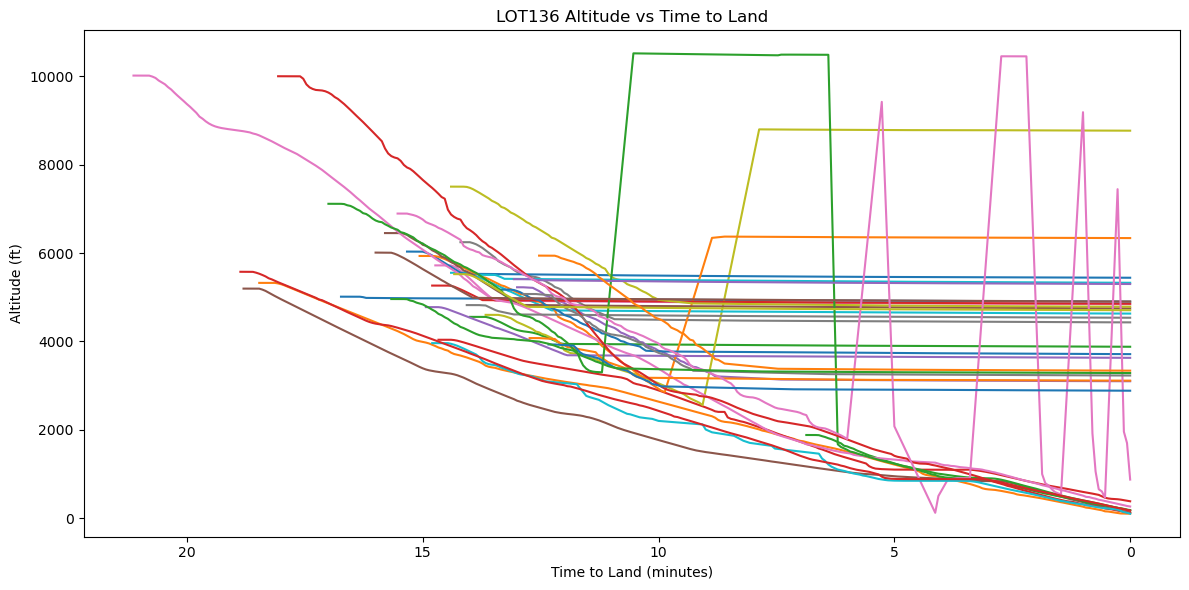

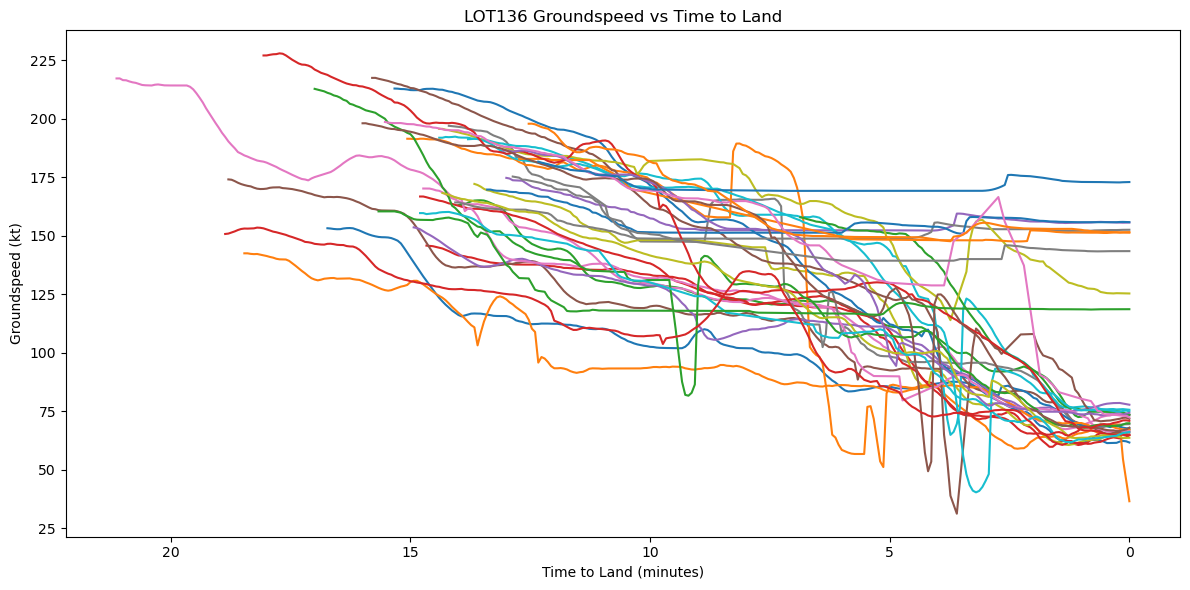

In [86]:
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
for flight in ste_traffic_lot136:
    data = flight.data
    t_land = (data['timestamp'].iloc[-1] - data['timestamp']).dt.total_seconds() / 60
    plt.plot(t_land, data['altitude'], label=f"{flight.callsign} ({flight.start:%Y-%m-%d})")
plt.xlabel('Time to Land (minutes)')
plt.ylabel('Altitude (ft)')
plt.title('LOT136 Altitude vs Time to Land')
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for flight in ste_traffic_lot136:
    data = flight.data
    t_land = (data['timestamp'].iloc[-1] - data['timestamp']).dt.total_seconds() / 60
    plt.plot(t_land, data['groundspeed'], label=f"{flight.callsign} ({flight.start:%Y-%m-%d})")
plt.xlabel('Time to Land (minutes)')
plt.ylabel('Groundspeed (kt)')
plt.title('LOT136 Groundspeed vs Time to Land')
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()


Most of the abnormal trajectories are caused by the error of altitude/groundspeed measurement.

# DTW 3D without DTW 2D anomalies
Now we check what types of anomalies are not detected by DTW 2D, but are detected by DTW 3D. We will check the trajectories of these flights.

In [90]:
dtw_2d_anomalies_identifiers = [
    f"{flight.callsign}_{flight.icao24}_{flight.start:%Y%m%d%H%M%S}"
    for flight in dtw_2d_traffic
]

dtw_3d_anomalies_identifiers = [
    f"{flight.callsign}_{flight.icao24}_{flight.start:%Y%m%d%H%M%S}"
    for flight in dtw_3d_traffic
]

In [91]:
dtw_3d_without_2d = [
    flight for flight in dtw_3d_traffic
    if f"{flight.callsign}_{flight.icao24}_{flight.start:%Y%m%d%H%M%S}" not in dtw_2d_anomalies_identifiers
]

In [92]:
len(dtw_3d_without_2d)

157

In [93]:
dtw_3d_without_2d_anomalies = []
for flight in dtw_3d_traffic:
    identifier = f"{flight.callsign}_{flight.icao24}_{flight.start:%Y%m%d%H%M%S}"
    if identifier not in dtw_2d_anomalies_identifiers:
        dtw_3d_without_2d_anomalies.append(flight)

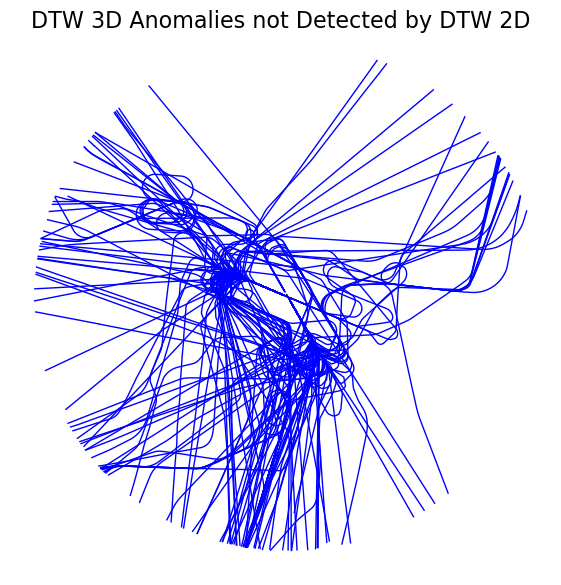

In [94]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_2180()))
    
    airports["EPWA"].plot(ax=ax, footprint=False, runways=dict(linewidth=1))
    for flight in dtw_3d_without_2d_anomalies:
        flight.plot(ax=ax, color="blue", linewidth=1, label=flight.callsign if flight.callsign else "Unknown Callsign")
    ax.set_title("DTW 3D Anomalies not Detected by DTW 2D")
    
    plt.show()

In [95]:
dtw_3d_without_2d_anomalies_fin1143 = [
    flight for flight in dtw_3d_without_2d_anomalies
    if flight.callsign == "FIN1143"
]

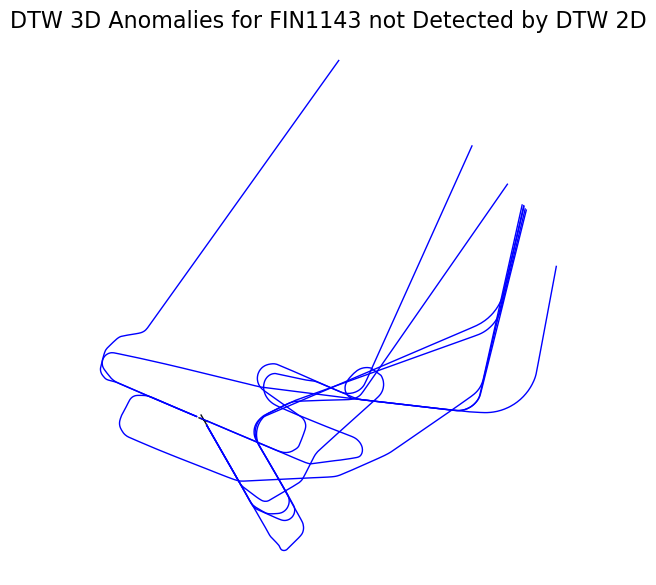

In [96]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_2180()))
    
    airports["EPWA"].plot(ax=ax, footprint=False, runways=dict(linewidth=1))
    for flight in dtw_3d_without_2d_anomalies_fin1143:
        flight.plot(ax=ax, color="blue", linewidth=1, label=flight.callsign if flight.callsign else "Unknown Callsign")
    ax.set_title("DTW 3D Anomalies for FIN1143 not Detected by DTW 2D")
    plt.show()

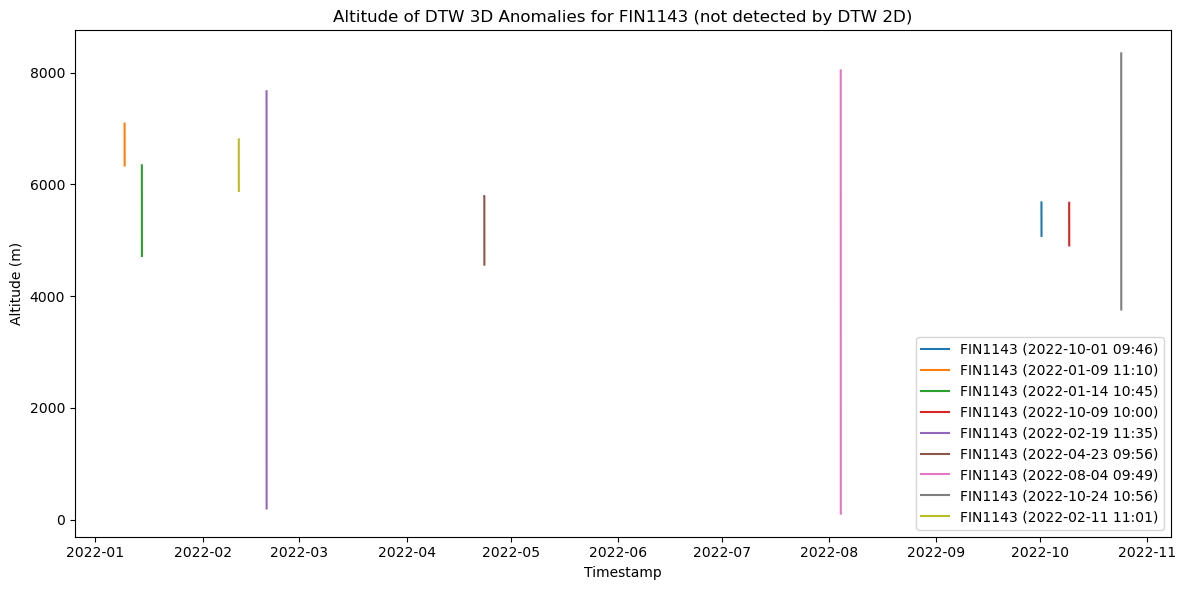

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for flight in dtw_3d_without_2d_anomalies_fin1143:
    data = flight.data
    plt.plot(data['timestamp'], data['altitude'], label=f"{flight.callsign} ({flight.start:%Y-%m-%d %H:%M})")
plt.xlabel('Timestamp')
plt.ylabel('Altitude (m)')
plt.title('Altitude of DTW 3D Anomalies for FIN1143 (not detected by DTW 2D)')
plt.legend()
plt.tight_layout()
plt.show()

Most of the flights have error in altitude measurement, altitude stop decreasing at 4000 meters. So only two flights are interesting:
- FIN1143 2022-02-19
- FIN1143 2022-08-04

In [102]:
dtw_2d_fin1143 = dtw_2d_traffic.query("callsign == 'FIN1143'")
dtw_2d_fin1143

icao24 callsign  count
0  461e1f  FIN1143   3623
1  461e1a  FIN1143   2569
2  461e14  FIN1143   2487
3  461e1c  FIN1143   1407
4  461e18  FIN1143   1256
5  461f31  FIN1143   1249

In [103]:
dtw_3d_without_2d_anomalies_fin1143_selected = [
    flight for flight in dtw_3d_without_2d_anomalies_fin1143
    if flight.start.date() in [pd.Timestamp("2022-02-19").date(), pd.Timestamp("2022-08-04").date()]
]

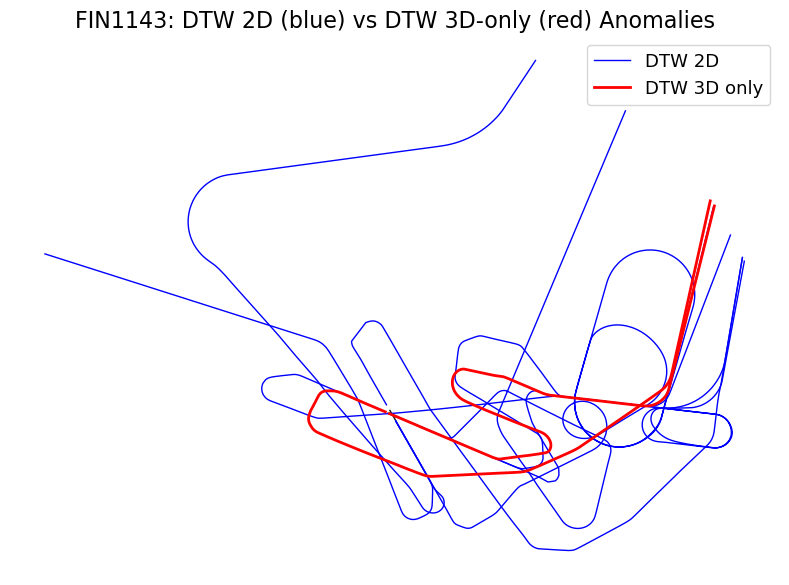

In [104]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_2180()))
    airports["EPWA"].plot(ax=ax, footprint=False, runways=dict(linewidth=1))

    # Plot DTW 2D FIN1143 flights in blue
    for flight in dtw_2d_fin1143:
        flight.plot(ax=ax, color="blue", linewidth=1, label="DTW 2D" if 'DTW 2D' not in ax.get_legend_handles_labels()[1] else "")

    # Plot DTW 3D without 2D FIN1143 selected flights in red
    for flight in dtw_3d_without_2d_anomalies_fin1143_selected:
        flight.plot(ax=ax, color="red", linewidth=2, label="DTW 3D only" if 'DTW 3D only' not in ax.get_legend_handles_labels()[1] else "")

    ax.set_title("FIN1143: DTW 2D (blue) vs DTW 3D-only (red) Anomalies")
    ax.legend()
    plt.show()